# Imports:

In [1]:
import os
import gc
import h5py
import random
import torch
import torch_directml
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode

In [2]:
def dice_score(pred_bin, target_bin, eps=1e-7):
    intersection = (pred_bin * target_bin).sum().float()
    denom = pred_bin.sum() + target_bin.sum()
    dice = (2.0 * intersection + eps) / (denom + eps)
    return dice

def iou_score(pred_bin, target_bin, eps=1e-7):
    intersection = (pred_bin * target_bin).sum().float()
    union = (pred_bin + target_bin - pred_bin * target_bin).sum().float()
    iou = (intersection + eps) / (union + eps)
    return iou

In [3]:
class BinaryFocalLoss(nn.Module):
    """
    Binary focal loss for single-channel segmentation tasks.

    Args:
        alpha (float): Weighting factor for the rare class, default=0.25
        gamma (float): Exponent to down-weight easy examples and focus training on hard examples, default=2.0
        reduction (str): 'mean' or 'sum'. Default='mean'
    """
    ##############################################################################
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    ##############################################################################
    def forward(self, inputs, targets):
        """
        inputs: (N, *) - raw logits (no sigmoid) from the model, shape (N, 1, H, W)
        targets: (N, *) - binary ground truth (0 or 1), shape (N, H, W) or (N, 1, H, W)
        """
        # Flatten the inputs for stable focal calculations: shape => (N, H*W)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(inputs)

        # Focal loss components
        pt = torch.where(targets == 1, probs, 1 - probs)  # pt = p if t==1 else (1-p)

        # Focal loss formula
        focal_weight = (self.alpha * targets + (1 - self.alpha) * (1 - targets)) * (1 - pt).pow(self.gamma)

        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss     

In [4]:
# Define a Squeeze-and-Excitation (SE) Block for channel attention.
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Data Generation:

In [5]:
class Train_Set_Gen():
    def __init__(self, params_range, num_of_points_k, num_of_points_w, img_range, bands_number=3):
        self.bands_number = bands_number  
        self.params_range = params_range
        self.img_range = img_range
        self.num_of_points_k = num_of_points_k
        self.num_of_points_w = num_of_points_w

    def multiband_spectra(self):
        # Setup spatial grid
        x_start, x_end = self.img_range['x']
        y_start, y_end = self.img_range['y']
        W = np.linspace(y_start, y_end, num=self.num_of_points_w)
        K = np.linspace(x_start, x_end, num=self.num_of_points_k)
        k, w = np.meshgrid(K, W)
        
        # Initialize empty spectra
        spectra = np.zeros((self.num_of_points_w, self.num_of_points_k))
        
        # Allow possibility of 1 bands
        random_bands = random.randint(1, self.bands_number)
        
        # Generate random parameters for each band
        alpha   = [random.uniform(*self.params_range['alpha']) for _ in range(random_bands)]
        lam     = [random.uniform(*self.params_range['lam']) for _ in range(random_bands)]
        m       = [random.uniform(*self.params_range['m']) for _ in range(random_bands)]
        l       = [random.uniform(*self.params_range['l']) for _ in range(random_bands)]
        # For each band, add a random offset in the k-direction
        k0_list = [random.uniform(x_start, x_end) for _ in range(random_bands)]
        Imp     = random.uniform(*self.params_range['Imp'])
        
        # Calculate pixel step sizes
        x_step = abs((x_start - x_end) / self.num_of_points_k)
        y_step = abs((y_start - y_end) / self.num_of_points_w)
        
        # Shirley background noise (quadratic in w)
        shirley = random.uniform(0.1, 0.2)
        shirley_noise = shirley * (w**2)
        
        # Build up the spectra from each band
        for i in range(random_bands):
            m_i      = m[i]
            l_i      = l[i]
            lam_i    = lam[i]
            alpha_i  = alpha[i]
            k0       = k0_list[i]
            sigm2    = alpha_i * (w**2) + Imp
            # Use a Lorentzian-like term with k-offset
            arr = 0.5 * sigm2 / (((1 - lam_i) * w - (m_i * (k - k0)**2 + l_i))**2 + (sigm2)**2)
            spectra += arr
        
        # Build the binary mask (disp): 0 for band region, 1 for background
        disp = np.full((self.num_of_points_w, self.num_of_points_k), 1.)
        for i in range(random_bands):
            m_i   = m[i]
            l_i   = l[i]
            lam_i = lam[i]
            k0    = k0_list[i]
            for mm in range(self.num_of_points_w):
                for nn in range(self.num_of_points_k):
                    w_val = mm * y_step + y_start
                    k_val = nn * x_step + x_start
                    if ((1 - lam_i) * w_val - (m_i * (k_val - k0)**2 + l_i))**2 < 0.005:
                        disp[mm, nn] = 0
        
        # Add Gaussian noise based on the noise_level parameter
        noise_level = random.uniform(*self.params_range['noise_level'])
        noise = np.random.normal(0, noise_level, spectra.shape)
        spectra_noise = spectra + noise + shirley_noise

        return spectra_noise, disp
    
    def create_train_data(self,set_len):
        x_train = []
        y_train = []
        for _ in range(set_len):
                x,y = self.multiband_spectra()
                x_train.append(x)
                y_train.append(y)
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_train = np.reshape(x_train,(-1,self.num_of_points_w,self.num_of_points_k,1))
        y_train = np.reshape(y_train,(-1,self.num_of_points_w,self.num_of_points_k,1))
        y_train = to_categorical(y_train)
        return (x_train,y_train)

In [33]:
class Fermi_level(Train_Set_Gen):
    def multiband_spectra(self):
        # Generate the main spectrum and mask
        spectra_noise, disp = super().multiband_spectra()
        
        # Apply Fermi cutoff
        x_start, x_end = self.img_range['x']
        y_start, y_end = self.img_range['y']
        W = np.linspace(y_start, y_end, num=self.num_of_points_w)
        K = np.linspace(x_start, x_end, num=self.num_of_points_k)
        k, w = np.meshgrid(K, W)
        kb = 8.617e-5
        T = random.uniform(10, 500)
        Ef = random.uniform(0., 0.3)
        exp_cut = 1.0 / (np.exp((w - Ef) / (kb * T)) + 1)
        
        # Apply the cutoff and normalize the spectrum
        res = spectra_noise * exp_cut
        eps = 1e-7
        std_val = np.std(res)
        spectra_noise = (res - np.mean(res)) / max(std_val, eps)
        outputs = torch.sigmoid(torch.from_numpy(spectra_noise))
        return outputs.detach().cpu().numpy(), np.round(disp * exp_cut)

In [34]:
params_range = {'lam': (0.5, 8.0),
                'm': (-4.0, 14.0),
                'l': (-0.2, 1.6),
                'alpha': (0.0, 5.0),
                'Imp': (0.0, 0.8),
                'noise_level': (0.0, 0.3)}

img_range = {'x': (-0.5, 0.5),
             'y': (-0.8, 0)}

fermi = Fermi_level(params_range,128,128,img_range,bands_number = 3)   

In [35]:
x_train, y_train = fermi.create_train_data(10000)
x_val, y_val = fermi.create_train_data(1000)

# Save Data:

In [36]:
# Save data to HDF5
with h5py.File('fermi_data_new.h5', 'w') as hf:
    hf.create_dataset('x_train', data=x_train)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('x_val', data=x_val)
    hf.create_dataset('y_val', data=y_val)

print("Data has been saved to fermi_data.h5.")

Data has been saved to fermi_data.h5.


# Load Data

In [5]:
# Load data from HDF5
with h5py.File('fermi_data_new.h5', 'r') as hf:
    x_train = hf['x_train'][:]
    y_train = hf['y_train'][:]
    x_val = hf['x_val'][:]
    y_val = hf['y_val'][:]

KeyboardInterrupt: 

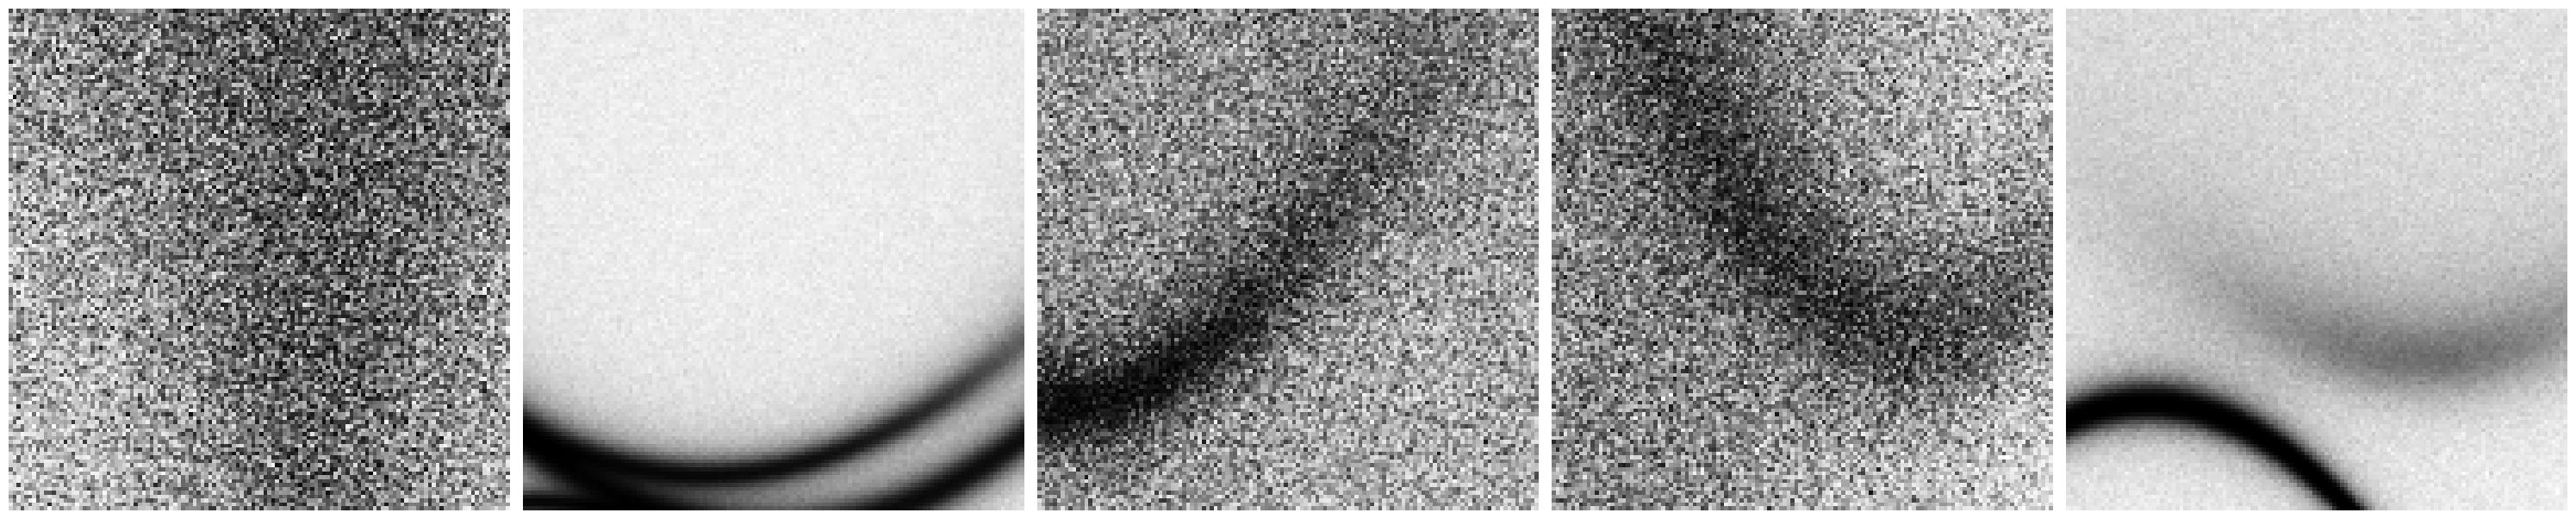

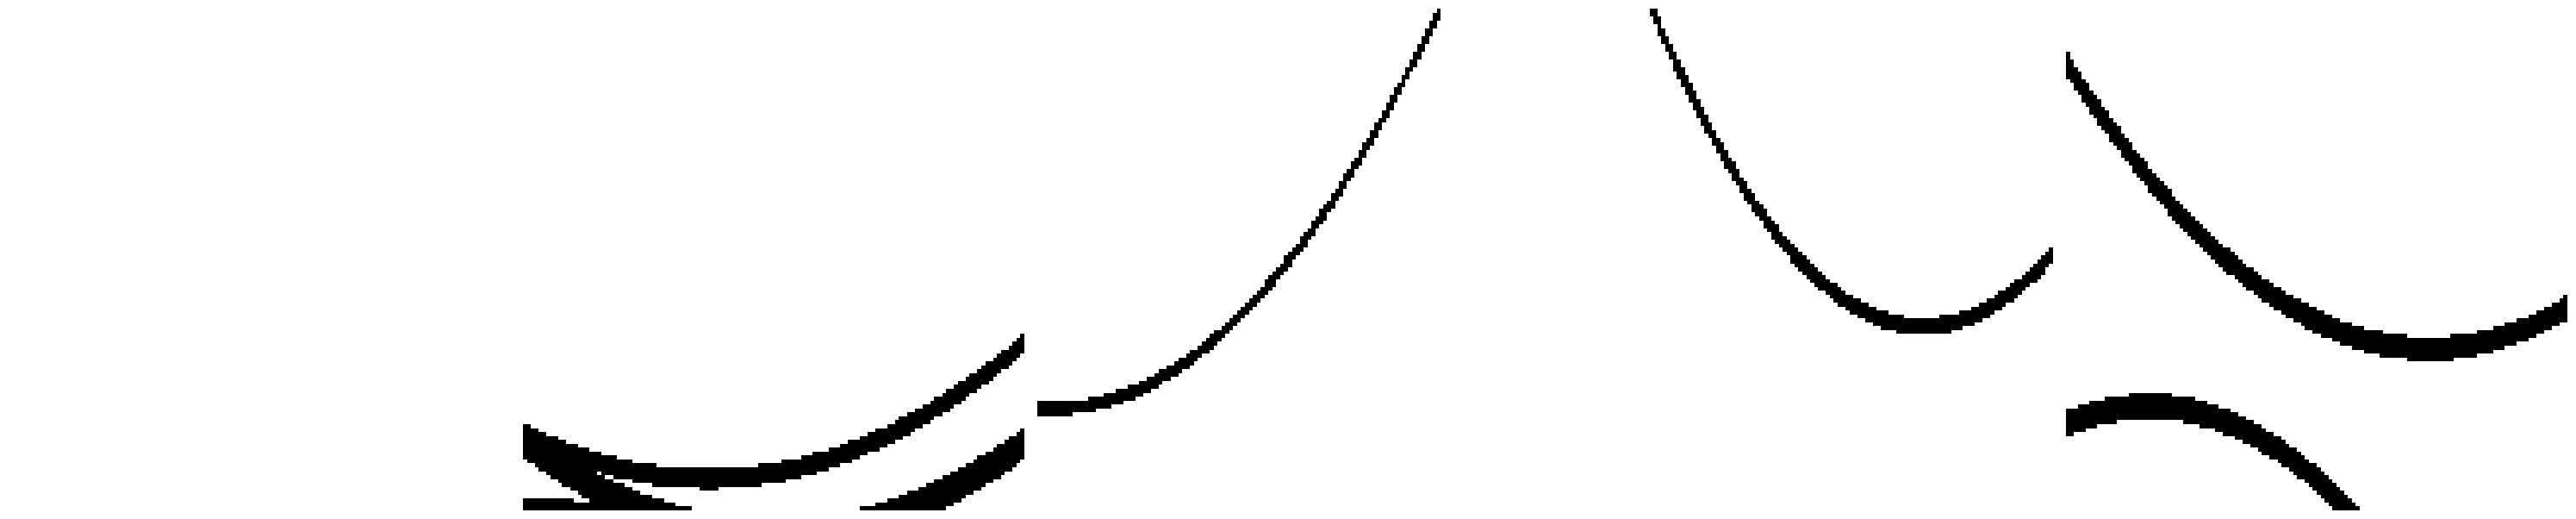

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

for i in range(5):
    axes[i].imshow(x_train[i, :, :, 0], cmap='gray_r')
    axes[i].axis('off')

plt.tight_layout()

fig, axes = plt.subplots(1, 5, figsize=(30, 10))

for i in range(5):
    axes[i].imshow(y_train[i, :, :, 0], cmap='gray_r')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Dataset Init:

In [13]:
# Helper function for elastic deformation
def elastic_transform_tensor(img, alpha, sigma, mode='bilinear'):
    # img shape: (C, H, W)
    c, h, w = img.shape
    # Create mesh grid
    grid_y, grid_x = torch.meshgrid(torch.arange(h, device=img.device), torch.arange(w, device=img.device), indexing='ij')
    grid = torch.stack((grid_x, grid_y), 2).float()  # shape: (H, W, 2)
    grid = grid.unsqueeze(0)  # shape: (1, H, W, 2)
    # Generate random displacement fields
    dx = torch.randn((1, h, w), device=img.device) * sigma * alpha
    dy = torch.randn((1, h, w), device=img.device) * sigma * alpha
    displacement = torch.stack((dx, dy), dim=3)  # shape: (1, H, W, 2)
    new_grid = grid + displacement
    # Normalize grid to [-1, 1]
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (w - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (h - 1) - 1.0
    img = img.unsqueeze(0)  # shape: (1, C, H, W)
    transformed = F.grid_sample(img, new_grid, mode=mode, padding_mode='reflection', align_corners=True)
    return transformed.squeeze(0)

# Joint Transform class that applies both geometric and intensity augmentations
class JointTransform:
    def __call__(self, x, y):
        # x, y: tensors of shape (C, H, W)
        
        # Geometric transforms (applied to both x and y):
        
        # Horizontal flip with probability 0.5
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
            
        # Small rotation with probability 0.5 (angle between -5 and 5 degrees)
        if torch.rand(1) < 0.5:
            angle = random.uniform(-5, 5)
            x = TF.rotate(x, angle, interpolation=InterpolationMode.BILINEAR)
            y = TF.rotate(y, angle, interpolation=InterpolationMode.NEAREST)
            
        # Translation with probability 0.5 (up to 5% of width/height)
        if torch.rand(1) < 0.5:
            max_dx = 0.05 * x.shape[2]
            max_dy = 0.05 * x.shape[1]
            translate_x = int(random.uniform(-max_dx, max_dx))
            translate_y = int(random.uniform(-max_dy, max_dy))
            x = TF.affine(x, angle=0, translate=[translate_x, translate_y], scale=1.0, shear=0, interpolation=InterpolationMode.BILINEAR)
            y = TF.affine(y, angle=0, translate=[translate_x, translate_y], scale=1.0, shear=0, interpolation=InterpolationMode.NEAREST)
            
        # Scaling (zoom) with probability 0.5 (scale factor between 0.9 and 1.1)
        if torch.rand(1) < 0.5:
            scale_factor = random.uniform(0.9, 1.1)
            x = TF.affine(x, angle=0, translate=[0, 0], scale=scale_factor, shear=0, interpolation=InterpolationMode.BILINEAR)
            y = TF.affine(y, angle=0, translate=[0, 0], scale=scale_factor, shear=0, interpolation=InterpolationMode.NEAREST)
            
        # Elastic deformation with probability 0.3
        if torch.rand(1) < 0.3:
            alpha_elastic = random.uniform(1, 3)
            sigma_elastic = random.uniform(3, 6)
            x = elastic_transform_tensor(x, alpha=alpha_elastic, sigma=sigma_elastic, mode='bilinear')
            y = elastic_transform_tensor(y, alpha=alpha_elastic, sigma=sigma_elastic, mode='nearest')
        
        # Intensity / photometric transforms (applied only to x):
        
        # Brightness adjustment with probability 0.5
        if torch.rand(1) < 0.5:
            brightness_factor = random.uniform(0.7, 1.3)
            x = x * brightness_factor
            x = x.clamp(0, 1)
            
        # Contrast adjustment (gamma correction) with probability 0.5
        if torch.rand(1) < 0.5:
            gamma = random.uniform(0.8, 1.2)
            x = x.pow(gamma)
            x = x.clamp(0, 1)
            
        # Noise injection with probability 0.3
        if torch.rand(1) < 0.3:
            noise_sigma = random.uniform(0.0, 0.05)
            noise = torch.randn_like(x) * noise_sigma
            x = x + noise
            x = x.clamp(0, 1)
            
        # Gaussian blur with probability 0.3
        if torch.rand(1) < 0.3:
            x = TF.gaussian_blur(x, kernel_size=[3, 3], sigma=random.uniform(0.1, 1.0))
            
        return x, y

# Custom dataset definition
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, input_transform=None, target_transform=None):
        """
        Args:
            x_data (numpy array): Input images of shape (N, H, W, 1).
            y_data (numpy array): Labels/masks of shape (N, H, W, 1) or (N, H, W, C).
            input_transform (callable, optional): Transform applied to input images only.
            target_transform (callable, optional): Transform applied to target masks only.
        """
        self.x_data = x_data
        self.y_data = y_data
        self.input_transform = input_transform
        self.target_transform = target_transform
        # Normalization transformation for inputs only (common for grayscale images in [0,1] range)
        self.normalize = transforms.Normalize(mean=[0.5], std=[0.5])

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Convert data from numpy to torch tensors and adjust shape to (C, H, W)
        x = self.x_data[idx].transpose(2, 0, 1)  # (1, H, W)
        y = self.y_data[idx].transpose(2, 0, 1)  # (C, H, W)

        # If the target has multiple channels, select the first one (binary mask)
        if y.shape[0] > 1:
            y = y[0:1, :, :]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Apply joint (coordinated) transforms if provided
        if self.input_transform is not None:
            x, y = self.input_transform(x, y)

        # Apply target transforms if provided (should not affect binary nature)
        if self.target_transform is not None:
            y = self.target_transform(y)

        # Normalize only the input image
        x = self.normalize(x)

        return x, y

In [14]:
joint_transform = JointTransform()
train_dataset = CustomDataset(x_train, y_train, input_transform=joint_transform)
# For validation, do not pass augmentations:
val_dataset = CustomDataset(x_val, y_val)

# Create DataLoaders (you may adjust batch_size as needed)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Sanity check: look at one batch
for inputs, targets in train_loader:
    print("Inputs shape:", inputs.shape)   # e.g., (8, 1, H, W)
    print("Targets shape:", targets.shape)   # e.g., (8, 1, H, W)
    break

Inputs shape: torch.Size([8, 1, 128, 128])
Targets shape: torch.Size([8, 1, 128, 128])


# Model Init:

In [6]:
# Setup device
device = torch_directml.device()

# 1. Initialize the model without pretrained weights
model = deeplabv3_resnet101(weights=None)

# 2. Modify the first convolution of the backbone to accept 1-channel grayscale input.
model.backbone.conv1 = nn.Conv2d(in_channels=1,
                                 out_channels=64,
                                 kernel_size=(7, 7),
                                 stride=(1, 1),
                                 padding=(3, 3),
                                 bias=False)
nn.init.kaiming_normal_(model.backbone.conv1.weight, nonlinearity='relu')

# 3. Modify the final classifier to output 1 channel for binary segmentation.
# The classifier is a Sequential module; its structure is roughly:
# [0] ASPP module, [1] conv, [2] batch norm, [3] ReLU, [4] final conv.
# Replace the final conv layer to output 1 channel.
model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
nn.init.kaiming_normal_(model.classifier[4].weight, nonlinearity='sigmoid')
if model.classifier[4].bias is not None:
    nn.init.constant_(model.classifier[4].bias, 0)

# Insert an SE block (attention mechanism) between the ReLU activation and the final conv.
se_block = SEBlock(256, reduction=16)

# Rebuild the classifier with the SE block inserted.
new_classifier = nn.Sequential(
    model.classifier[0],  # ASPP module
    model.classifier[1],  # Conv layer
    model.classifier[2],  # BatchNorm layer
    model.classifier[3],  # ReLU activation
    se_block,             # SE attention block
    model.classifier[4]   # Final conv layer (outputs 1 channel)
)
model.classifier = new_classifier

# 4. Move the model to GPU if available
model.to(device)

# --- Criterion: Binary Focal Loss (assumed defined elsewhere) ---
criterion = BinaryFocalLoss(alpha=0.5, gamma=1.5, reduction='mean')

# --- Optimizer: AdamW with moderate LR and weight decay ---
optimizer = optim.AdamW(model.parameters(), lr=1.0e-4, weight_decay=1.e-4)

# --- Scheduler: ReduceLROnPlateau based on validation loss ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, start_epoch=0):
    """
    Trains a binary segmentation model with a given criterion, optimizer, and scheduler.
    
    Args:
        model (nn.Module): The segmentation model (e.g., DeepLabV3) with a single output channel.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler): LR scheduler.
        epochs (int): Total number of epochs to train.
        device (torch.device): The device to use.
        start_epoch (int): The epoch to resume from (default: 0).
    
    Returns:
        (train_losses, val_losses, train_dices, val_dices, train_ious, val_ious):
            Lists of training/validation losses, dice scores, and IoU per epoch.
    """
    
    # Lists to store metrics over epochs
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []

    # Continue training from start_epoch+1
    for epoch in range(start_epoch + 1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou_sum = 0.0
        running_samples = 0  # Track total samples processed so far
        
        with tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
            for inputs, targets in pbar:
                batch_size = inputs.size(0)
                running_samples += batch_size

                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)['out']  # shape: (N,1,H,W)

                # Squeeze to (N,H,W)
                outputs = outputs.squeeze(1)
                targets = targets.squeeze(1)

                # Compute loss
                loss = criterion(outputs, targets)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss
                train_loss += loss.item() * batch_size

                # Dice & IoU calculations
                with torch.no_grad():
                    preds = torch.sigmoid(outputs)  # get probabilities in [0,1]
                    preds_bin = (preds > 0.5).float()  # binarize predictions
                    
                    batch_dice = dice_score(preds_bin, targets)
                    train_dice += batch_dice.item() * batch_size
                    
                    batch_iou = iou_score(preds_bin, targets)
                    train_iou_sum += batch_iou.item() * batch_size

                current_loss_avg = train_loss / running_samples
                pbar.set_postfix(train_loss=current_loss_avg)

        # Compute average metrics over training set
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_dice = train_dice / len(train_loader.dataset)
        epoch_train_iou = train_iou_sum / len(train_loader.dataset)

        # Validation
        val_loss, val_dice, val_iou = validate_model(model, val_loader, criterion, device)

        # Scheduler step (using validation loss)
        scheduler.step(val_loss)

        # Print epoch metrics
        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Train Dice: {epoch_train_dice:.4f}, "
              f"Train IoU: {epoch_train_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Dice: {val_dice:.4f}, "
              f"Val IoU: {val_iou:.4f}")

        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)
        train_dices.append(epoch_train_dice)
        val_dices.append(val_dice)
        train_ious.append(epoch_train_iou)
        val_ious.append(val_iou)

        # ------------------------
        # SAVE THE MODEL CHECKPOINT
        # ------------------------
        checkpoint_path = f"ckpt/checkpoint_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': val_loss,
            'train_dice': epoch_train_dice,
            'val_dice': val_dice,
            'train_iou': epoch_train_iou,
            'val_iou': val_iou,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious

# --- Validation Loop ---
def validate_model(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation set.
    
    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): Validation DataLoader.
        criterion (nn.Module): Loss function.
        device (torch.device): The device to use.
    
    Returns:
        (avg_val_loss, avg_val_dice, avg_val_iou):
            Average validation loss, dice score, and IoU.
    """
    model.eval()
    val_loss = 0.0
    val_dice_sum = 0.0
    val_iou_sum = 0.0
    running_samples = 0

    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, targets in pbar:
                batch_size = inputs.size(0)
                running_samples += batch_size

                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)['out']  # shape: (N,1,H,W)

                # Squeeze
                outputs = outputs.squeeze(1)
                targets = targets.squeeze(1)

                loss = criterion(outputs, targets)
                val_loss += loss.item() * batch_size

                preds = torch.sigmoid(outputs)
                preds_bin = (preds > 0.5).float()
                
                batch_dice = dice_score(preds_bin, targets)
                val_dice_sum += batch_dice.item() * batch_size
                
                batch_iou = iou_score(preds_bin, targets)
                val_iou_sum += batch_iou.item() * batch_size

                current_val_loss_avg = val_loss / running_samples
                pbar.set_postfix(val_loss=current_val_loss_avg)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_dice = val_dice_sum / len(val_loader.dataset)
    avg_val_iou = val_iou_sum / len(val_loader.dataset)
    
    return avg_val_loss, avg_val_dice, avg_val_iou

# Load model:

In [7]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path, device):
    """
    Loads model, optimizer, and scheduler state dictionaries from a checkpoint.

    Args:
        model (nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.
        scheduler (torch.optim.lr_scheduler): The scheduler to load the state into.
        checkpoint_path (str): Path to the checkpoint file.
        device (torch.device): Device on which to load the checkpoint.
    
    Returns:
        start_epoch (int): The epoch to resume training from.
    """
    # Load the checkpoint onto the CPU first
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load scheduler state
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # Retrieve the last completed epoch to resume from
    start_epoch = checkpoint['epoch']
    
    # Move the model to the desired device
    model.to(device)
    
    print(f"Checkpoint loaded from {checkpoint_path}, resuming at epoch {start_epoch}")
    return start_epoch

In [14]:
checkpoint_path = "ckpt1/checkpoint_epoch_8.pth"
start_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path, device)

C:\Users\maxog\AppData\Local\Temp\ipykernel_13176\776688531.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")

Checkpoint loaded from ckpt1/checkpoint_epoch_8.pth, resuming at epoch 8


# Train Model:

In [ ]:
start_epoch=0

In [ ]:
epochs=50
train_losses, val_losses, train_dices, val_dices, train_ious, val_ious = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    epochs, 
    device,
    start_epoch=start_epoch
)

Epoch 1/50:   0%|          | 0/1250 [00:00<?, ?batch/s]c:\Users\maxog\anaconda3\envs\torch_dml_env\lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)
Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0289]


[Epoch 1/50] Train Loss: 0.0362, Train Dice: 0.2262, Train IoU: 0.1319, Val Loss: 0.0289, Val Dice: 0.4224, Val IoU: 0.2722
Checkpoint saved to ckpt/checkpoint_epoch_1.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0274]


[Epoch 2/50] Train Loss: 0.0315, Train Dice: 0.3183, Train IoU: 0.1936, Val Loss: 0.0274, Val Dice: 0.4484, Val IoU: 0.2932
Checkpoint saved to ckpt/checkpoint_epoch_2.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0264]


[Epoch 3/50] Train Loss: 0.0306, Train Dice: 0.3439, Train IoU: 0.2120, Val Loss: 0.0264, Val Dice: 0.4503, Val IoU: 0.2949
Checkpoint saved to ckpt/checkpoint_epoch_3.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.72batch/s, val_loss=0.0252]


[Epoch 4/50] Train Loss: 0.0296, Train Dice: 0.3682, Train IoU: 0.2310, Val Loss: 0.0252, Val Dice: 0.5056, Val IoU: 0.3431
Checkpoint saved to ckpt/checkpoint_epoch_4.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.74batch/s, val_loss=0.0255]


[Epoch 5/50] Train Loss: 0.0290, Train Dice: 0.3836, Train IoU: 0.2424, Val Loss: 0.0255, Val Dice: 0.5343, Val IoU: 0.3693
Checkpoint saved to ckpt/checkpoint_epoch_5.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0255]


[Epoch 6/50] Train Loss: 0.0283, Train Dice: 0.4003, Train IoU: 0.2557, Val Loss: 0.0255, Val Dice: 0.5389, Val IoU: 0.3733
Checkpoint saved to ckpt/checkpoint_epoch_6.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.76batch/s, val_loss=0.0233]


[Epoch 7/50] Train Loss: 0.0279, Train Dice: 0.4107, Train IoU: 0.2649, Val Loss: 0.0233, Val Dice: 0.5488, Val IoU: 0.3835
Checkpoint saved to ckpt/checkpoint_epoch_7.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0234]


[Epoch 8/50] Train Loss: 0.0276, Train Dice: 0.4190, Train IoU: 0.2717, Val Loss: 0.0234, Val Dice: 0.5526, Val IoU: 0.3868
Checkpoint saved to ckpt/checkpoint_epoch_8.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0227]


[Epoch 9/50] Train Loss: 0.0272, Train Dice: 0.4267, Train IoU: 0.2788, Val Loss: 0.0227, Val Dice: 0.5833, Val IoU: 0.4171
Checkpoint saved to ckpt/checkpoint_epoch_9.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0224]


[Epoch 10/50] Train Loss: 0.0268, Train Dice: 0.4374, Train IoU: 0.2871, Val Loss: 0.0224, Val Dice: 0.5696, Val IoU: 0.4037
Checkpoint saved to ckpt/checkpoint_epoch_10.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0232]


[Epoch 11/50] Train Loss: 0.0264, Train Dice: 0.4426, Train IoU: 0.2918, Val Loss: 0.0232, Val Dice: 0.5801, Val IoU: 0.4148
Checkpoint saved to ckpt/checkpoint_epoch_11.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.76batch/s, val_loss=0.0241]


[Epoch 12/50] Train Loss: 0.0264, Train Dice: 0.4452, Train IoU: 0.2935, Val Loss: 0.0241, Val Dice: 0.5618, Val IoU: 0.3953
Checkpoint saved to ckpt/checkpoint_epoch_12.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0232]


[Epoch 13/50] Train Loss: 0.0260, Train Dice: 0.4535, Train IoU: 0.3007, Val Loss: 0.0232, Val Dice: 0.5882, Val IoU: 0.4218
Checkpoint saved to ckpt/checkpoint_epoch_13.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0216]


[Epoch 14/50] Train Loss: 0.0260, Train Dice: 0.4576, Train IoU: 0.3049, Val Loss: 0.0216, Val Dice: 0.6100, Val IoU: 0.4435
Checkpoint saved to ckpt/checkpoint_epoch_14.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0244]


[Epoch 15/50] Train Loss: 0.0257, Train Dice: 0.4623, Train IoU: 0.3081, Val Loss: 0.0244, Val Dice: 0.5719, Val IoU: 0.4057
Checkpoint saved to ckpt/checkpoint_epoch_15.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0225]


[Epoch 16/50] Train Loss: 0.0254, Train Dice: 0.4677, Train IoU: 0.3130, Val Loss: 0.0225, Val Dice: 0.6120, Val IoU: 0.4467
Checkpoint saved to ckpt/checkpoint_epoch_16.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.72batch/s, val_loss=0.021] 


[Epoch 17/50] Train Loss: 0.0252, Train Dice: 0.4734, Train IoU: 0.3184, Val Loss: 0.0210, Val Dice: 0.6039, Val IoU: 0.4384
Checkpoint saved to ckpt/checkpoint_epoch_17.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.72batch/s, val_loss=0.0217]


[Epoch 18/50] Train Loss: 0.0252, Train Dice: 0.4751, Train IoU: 0.3196, Val Loss: 0.0217, Val Dice: 0.6096, Val IoU: 0.4437
Checkpoint saved to ckpt/checkpoint_epoch_18.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0211]


[Epoch 19/50] Train Loss: 0.0248, Train Dice: 0.4819, Train IoU: 0.3259, Val Loss: 0.0211, Val Dice: 0.6207, Val IoU: 0.4554
Checkpoint saved to ckpt/checkpoint_epoch_19.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0213]


[Epoch 20/50] Train Loss: 0.0247, Train Dice: 0.4849, Train IoU: 0.3282, Val Loss: 0.0213, Val Dice: 0.6051, Val IoU: 0.4392
Checkpoint saved to ckpt/checkpoint_epoch_20.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0217]


[Epoch 21/50] Train Loss: 0.0246, Train Dice: 0.4802, Train IoU: 0.3249, Val Loss: 0.0217, Val Dice: 0.6186, Val IoU: 0.4527
Checkpoint saved to ckpt/checkpoint_epoch_21.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0209]


[Epoch 22/50] Train Loss: 0.0246, Train Dice: 0.4854, Train IoU: 0.3288, Val Loss: 0.0209, Val Dice: 0.6230, Val IoU: 0.4583
Checkpoint saved to ckpt/checkpoint_epoch_22.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0213]


[Epoch 23/50] Train Loss: 0.0244, Train Dice: 0.4938, Train IoU: 0.3368, Val Loss: 0.0213, Val Dice: 0.6172, Val IoU: 0.4524
Checkpoint saved to ckpt/checkpoint_epoch_23.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.73batch/s, val_loss=0.0212]


[Epoch 24/50] Train Loss: 0.0241, Train Dice: 0.5002, Train IoU: 0.3419, Val Loss: 0.0212, Val Dice: 0.6173, Val IoU: 0.4517
Checkpoint saved to ckpt/checkpoint_epoch_24.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0214]


[Epoch 25/50] Train Loss: 0.0239, Train Dice: 0.5020, Train IoU: 0.3439, Val Loss: 0.0214, Val Dice: 0.6352, Val IoU: 0.4711
Checkpoint saved to ckpt/checkpoint_epoch_25.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.73batch/s, val_loss=0.0208]


[Epoch 26/50] Train Loss: 0.0240, Train Dice: 0.4984, Train IoU: 0.3408, Val Loss: 0.0208, Val Dice: 0.6434, Val IoU: 0.4796
Checkpoint saved to ckpt/checkpoint_epoch_26.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0215]


[Epoch 27/50] Train Loss: 0.0237, Train Dice: 0.5079, Train IoU: 0.3491, Val Loss: 0.0215, Val Dice: 0.6365, Val IoU: 0.4721
Checkpoint saved to ckpt/checkpoint_epoch_27.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0212]


[Epoch 28/50] Train Loss: 0.0236, Train Dice: 0.5091, Train IoU: 0.3503, Val Loss: 0.0212, Val Dice: 0.6370, Val IoU: 0.4737
Checkpoint saved to ckpt/checkpoint_epoch_28.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0213]


[Epoch 29/50] Train Loss: 0.0235, Train Dice: 0.5142, Train IoU: 0.3549, Val Loss: 0.0213, Val Dice: 0.6315, Val IoU: 0.4665
Checkpoint saved to ckpt/checkpoint_epoch_29.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.73batch/s, val_loss=0.0202]


[Epoch 30/50] Train Loss: 0.0233, Train Dice: 0.5185, Train IoU: 0.3588, Val Loss: 0.0202, Val Dice: 0.6390, Val IoU: 0.4751
Checkpoint saved to ckpt/checkpoint_epoch_30.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0205]


[Epoch 31/50] Train Loss: 0.0234, Train Dice: 0.5161, Train IoU: 0.3573, Val Loss: 0.0205, Val Dice: 0.6499, Val IoU: 0.4868
Checkpoint saved to ckpt/checkpoint_epoch_31.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.74batch/s, val_loss=0.0207]


[Epoch 32/50] Train Loss: 0.0231, Train Dice: 0.5195, Train IoU: 0.3607, Val Loss: 0.0207, Val Dice: 0.6575, Val IoU: 0.4946
Checkpoint saved to ckpt/checkpoint_epoch_32.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0213]


[Epoch 33/50] Train Loss: 0.0230, Train Dice: 0.5274, Train IoU: 0.3674, Val Loss: 0.0213, Val Dice: 0.6584, Val IoU: 0.4962
Checkpoint saved to ckpt/checkpoint_epoch_33.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0205]


[Epoch 34/50] Train Loss: 0.0230, Train Dice: 0.5222, Train IoU: 0.3632, Val Loss: 0.0205, Val Dice: 0.6470, Val IoU: 0.4833
Checkpoint saved to ckpt/checkpoint_epoch_34.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0201]


[Epoch 35/50] Train Loss: 0.0229, Train Dice: 0.5270, Train IoU: 0.3675, Val Loss: 0.0201, Val Dice: 0.6483, Val IoU: 0.4857
Checkpoint saved to ckpt/checkpoint_epoch_35.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0201]


[Epoch 36/50] Train Loss: 0.0226, Train Dice: 0.5342, Train IoU: 0.3735, Val Loss: 0.0201, Val Dice: 0.6605, Val IoU: 0.4978
Checkpoint saved to ckpt/checkpoint_epoch_36.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0202]


[Epoch 37/50] Train Loss: 0.0228, Train Dice: 0.5297, Train IoU: 0.3694, Val Loss: 0.0202, Val Dice: 0.6663, Val IoU: 0.5050
Checkpoint saved to ckpt/checkpoint_epoch_37.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0209]


[Epoch 38/50] Train Loss: 0.0229, Train Dice: 0.5252, Train IoU: 0.3657, Val Loss: 0.0209, Val Dice: 0.6672, Val IoU: 0.5060
Checkpoint saved to ckpt/checkpoint_epoch_38.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0204]


[Epoch 39/50] Train Loss: 0.0224, Train Dice: 0.5418, Train IoU: 0.3808, Val Loss: 0.0204, Val Dice: 0.6732, Val IoU: 0.5127
Checkpoint saved to ckpt/checkpoint_epoch_39.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.021] 


[Epoch 40/50] Train Loss: 0.0222, Train Dice: 0.5450, Train IoU: 0.3842, Val Loss: 0.0210, Val Dice: 0.6312, Val IoU: 0.4673
Checkpoint saved to ckpt/checkpoint_epoch_40.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0206]


[Epoch 41/50] Train Loss: 0.0222, Train Dice: 0.5421, Train IoU: 0.3817, Val Loss: 0.0206, Val Dice: 0.6549, Val IoU: 0.4927
Checkpoint saved to ckpt/checkpoint_epoch_41.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.75batch/s, val_loss=0.0196]


[Epoch 42/50] Train Loss: 0.0212, Train Dice: 0.5676, Train IoU: 0.4059, Val Loss: 0.0196, Val Dice: 0.6769, Val IoU: 0.5172
Checkpoint saved to ckpt/checkpoint_epoch_42.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.0202]


[Epoch 43/50] Train Loss: 0.0210, Train Dice: 0.5730, Train IoU: 0.4117, Val Loss: 0.0202, Val Dice: 0.6826, Val IoU: 0.5245
Checkpoint saved to ckpt/checkpoint_epoch_43.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0212]


[Epoch 44/50] Train Loss: 0.0206, Train Dice: 0.5832, Train IoU: 0.4217, Val Loss: 0.0212, Val Dice: 0.6817, Val IoU: 0.5230
Checkpoint saved to ckpt/checkpoint_epoch_44.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.76batch/s, val_loss=0.0208]


[Epoch 45/50] Train Loss: 0.0205, Train Dice: 0.5869, Train IoU: 0.4257, Val Loss: 0.0208, Val Dice: 0.6883, Val IoU: 0.5305
Checkpoint saved to ckpt/checkpoint_epoch_45.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0206]


[Epoch 46/50] Train Loss: 0.0205, Train Dice: 0.5860, Train IoU: 0.4244, Val Loss: 0.0206, Val Dice: 0.6863, Val IoU: 0.5283
Checkpoint saved to ckpt/checkpoint_epoch_46.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.71batch/s, val_loss=0.0212]


[Epoch 47/50] Train Loss: 0.0202, Train Dice: 0.5930, Train IoU: 0.4312, Val Loss: 0.0212, Val Dice: 0.6831, Val IoU: 0.5246
Checkpoint saved to ckpt/checkpoint_epoch_47.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0217]


[Epoch 48/50] Train Loss: 0.0201, Train Dice: 0.5946, Train IoU: 0.4331, Val Loss: 0.0217, Val Dice: 0.6829, Val IoU: 0.5239
Checkpoint saved to ckpt/checkpoint_epoch_48.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.70batch/s, val_loss=0.0212]


[Epoch 49/50] Train Loss: 0.0194, Train Dice: 0.6149, Train IoU: 0.4540, Val Loss: 0.0212, Val Dice: 0.6902, Val IoU: 0.5331
Checkpoint saved to ckpt/checkpoint_epoch_49.pth


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.69batch/s, val_loss=0.021] 


[Epoch 50/50] Train Loss: 0.0197, Train Dice: 0.6095, Train IoU: 0.4481, Val Loss: 0.0210, Val Dice: 0.6879, Val IoU: 0.5300
Checkpoint saved to ckpt/checkpoint_epoch_50.pth


# Save Metrics:

In [1]:
def save_metrics(
    metrics_dir,
    train_losses, val_losses,
    train_dices,  val_dices,
    train_ious,   val_ious,
    start_epoch=1
):
    """
    Appends (or creates) a single CSV file metrics/metrics.csv with columns:
      epoch, train_loss, val_loss, train_dice, val_dice, train_iou, val_iou
    """
    os.makedirs(metrics_dir, exist_ok=True)
    path = os.path.join(metrics_dir, 'metrics.csv')

    # build a DataFrame for this run
    df = pd.DataFrame({
        'epoch':      list(range(start_epoch, start_epoch + len(train_losses))),
        'train_loss': train_losses,
        'val_loss':   val_losses,
        'train_dice': train_dices,
        'val_dice':   val_dices,
        'train_iou':  train_ious,
        'val_iou':    val_ious,
    })

    # append if exists, otherwise write header
    if os.path.exists(path):
        df.to_csv(path, mode='a', index=False, header=False)
    else:
        df.to_csv(path, index=False)

In [ ]:
save_metrics(
    metrics_dir='metrics',
    train_losses=train_losses,
    val_losses=val_losses,
    train_dices=train_dices,
    val_dices=val_dices,
    train_ious=train_ious,
    val_ious=val_ious,
    start_epoch=start_epoch
)

NameError: name 'train_losses' is not defined

In [1]:
import re
import pandas as pd
import os

# 1) Load your raw log
with open('training.log', 'r') as f:
    log_text = f.read()

# 2) Regex to capture:
#    epoch, train_loss, train_dice, train_iou, val_loss, val_dice, val_iou
pattern = re.compile(
    r"\[Epoch\s+(\d+)/\d+\]\s*"
    r"Train Loss:\s*([\d.]+),\s*"
    r"Train Dice:\s*([\d.]+),\s*"
    r"Train IoU:\s*([\d.]+),\s*"
    r"Val Loss:\s*([\d.]+),\s*"
    r"Val Dice:\s*([\d.]+),\s*"
    r"Val IoU:\s*([\d.]+)"
)

records = []
for m in pattern.finditer(log_text):
    epoch, t_loss, t_dice, t_iou, v_loss, v_dice, v_iou = m.groups()
    records.append({
        'epoch':       int(epoch),
        'train_loss':  float(t_loss),
        'val_loss':    float(v_loss),
        'train_dice':  float(t_dice),
        'val_dice':    float(v_dice),
        'train_iou':   float(t_iou),
        'val_iou':     float(v_iou),
    })

# 3) Save to metrics/metrics.csv
os.makedirs('metrics', exist_ok=True)
df = pd.DataFrame(records)
df.to_csv('metrics/metrics.csv', index=False)
print(f"Extracted {len(df)} epochs → saved to metrics/metrics.csv")


Extracted 50 epochs → saved to metrics/metrics.csv


# Visualize Metrics:

In [6]:
df = pd.read_csv('metrics/metrics.csv')

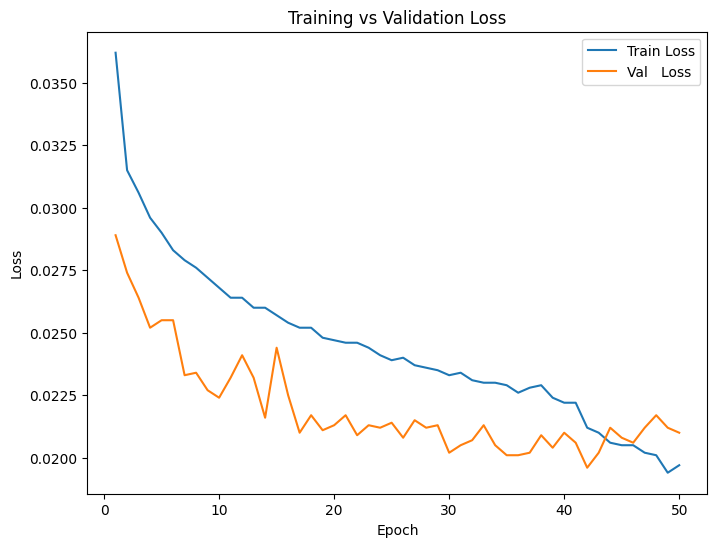

In [7]:
# LOSS
plt.figure(figsize=(8, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'],   label='Val   Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

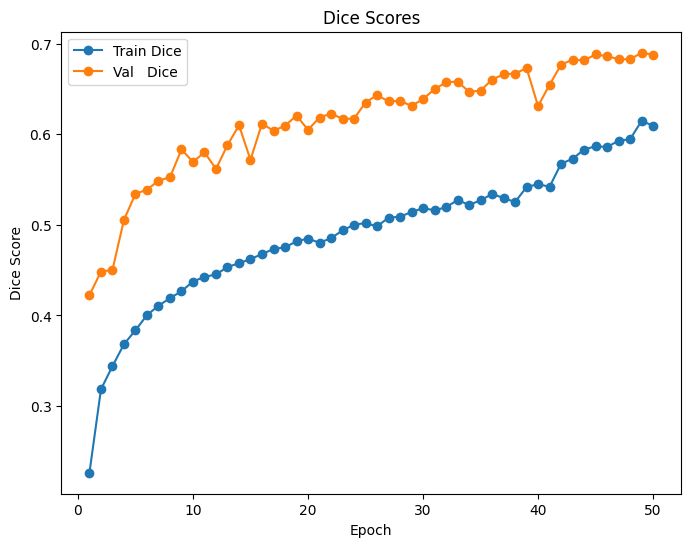

In [8]:
# DICE
plt.figure(figsize=(8, 6))
plt.plot(df['epoch'], df['train_dice'], label='Train Dice', marker='o')
plt.plot(df['epoch'], df['val_dice'],   label='Val   Dice', marker='o')
plt.xlabel('Epoch'); plt.ylabel('Dice Score')
plt.title('Dice Scores')
plt.legend()
plt.show()

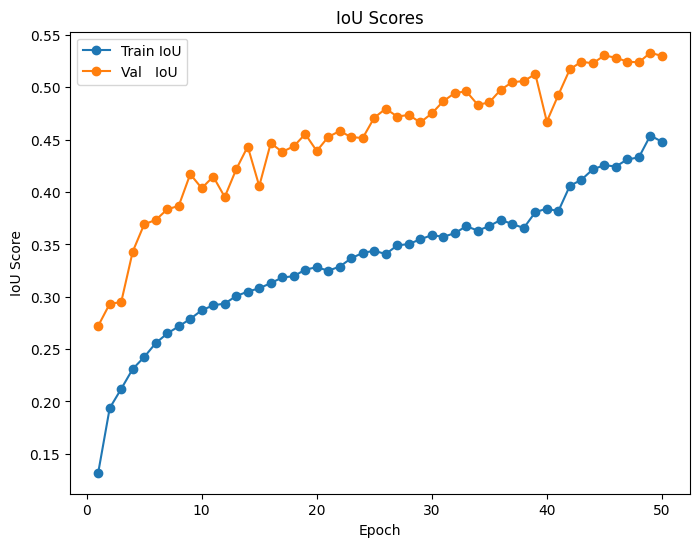

In [9]:
# IoU
plt.figure(figsize=(8, 6))
plt.plot(df['epoch'], df['train_iou'], label='Train IoU', marker='o')
plt.plot(df['epoch'], df['val_iou'],   label='Val   IoU', marker='o')
plt.xlabel('Epoch'); plt.ylabel('IoU Score')
plt.title('IoU Scores')
plt.legend()
plt.show()

In [18]:
def analyze_val_distribution(model, val_loader, device):
    """
    Обчислює Dice Score та IoU для кожного зображення з val_loader,
    будує гістограми для обох метрик, а також виводить середнє та дисперсію.
    Використовує менторські функції (dice_coef, iou), що працюють з масивами NumPy.

    Args:
        model (nn.Module): Тренована сегментаційна модель.
        val_loader (DataLoader): DataLoader для валідаційного набору.
        device (torch.device): 'cpu' або 'cuda'.
    """

    def dice_coef(groundtruth_mask, pred_mask, eps=1e-7):
        intersect = np.sum(pred_mask * groundtruth_mask)
        total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
        dice_val = (2.0 * intersect + eps) / (total_sum + eps)
        return round(dice_val, 5)

    def iou(groundtruth_mask, pred_mask, eps=1e-7):
        intersect = np.sum(pred_mask * groundtruth_mask)
        union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
        iou_val = (intersect + eps) / (union + eps)
        return round(iou_val, 5)


    model.eval()
    dice_vals = []
    iou_vals = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Прямий прохід (forward pass)
            outputs = model(inputs)['out']  # (N, 1, H, W)
            
            # Звужуємо (N, 1, H, W) -> (N, H, W)
            outputs = outputs.squeeze(1)
            targets = targets.squeeze(1)

            # Знаходимо ймовірності та бінаризуємо
            probs = torch.sigmoid(outputs)
            preds_bin = (probs > 0.5).float()  # поріг 0.5

            # Для кожного семплу в batch обчислюємо Dice та IoU
            batch_size = preds_bin.size(0)
            for i in range(batch_size):
                # 1) Flatten (H,W)->(H*W,) so each mask is 1D
                pred_flat = preds_bin[i].view(-1).cpu().numpy()
                target_flat = targets[i].view(-1).cpu().numpy()

                # 2) Обчислюємо менторські метрики
                dice_val = dice_coef(target_flat, pred_flat)
                iou_val  = iou(target_flat, pred_flat)

                dice_vals.append(dice_val)
                iou_vals.append(iou_val)

    # Перетворимо списки у numpy-масиви, щоб зручно рахувати середнє/дисперсію
    dice_vals_np = np.array(dice_vals, dtype=np.float32)
    iou_vals_np  = np.array(iou_vals, dtype=np.float32)

    dice_mean = dice_vals_np.mean()
    dice_var  = dice_vals_np.var()

    iou_mean = iou_vals_np.mean()
    iou_var  = iou_vals_np.var()

    # Відображаємо гістограми
    plt.figure(figsize=(10, 4))

    # Гістограма Dice Score
    plt.subplot(1, 2, 1)
    plt.hist(dice_vals_np, bins=20, range=(0, 1))
    plt.title("Dice Score Distribution")
    plt.xlabel("Dice")
    plt.ylabel("Frequency")

    # Гістограма IoU
    plt.subplot(1, 2, 2)
    plt.hist(iou_vals_np, bins=20, range=(0, 1))
    plt.title("IoU Distribution")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # Вивід у консоль
    print(f"Dice Score: mean={dice_mean:.4f}, var={dice_var:.4f}")
    print(f"IoU: mean={iou_mean:.4f}, var={iou_var:.4f}")


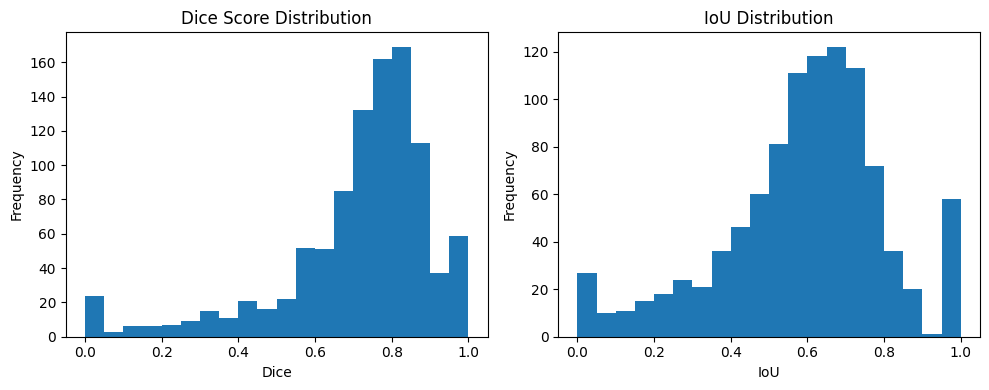

Dice Score: mean=0.7153, var=0.0410
IoU: mean=0.5898, var=0.0459


In [19]:
analyze_val_distribution(model,val_loader,device)

# Visualize on validation dataset:

In [20]:
def visualize_segmentation_results(model, val_dataset, device, num_samples=10):
    """
    Visualize the spectre (x_sample), the theoretical mask (y_sample),
    and the model's segmentation result for a few samples from val_dataset.

    Also prints Dice Score and IoU for each sample on the final subplot.

    Args:
        model (nn.Module): Trained segmentation model (e.g., DeepLabV3).
        val_dataset (Dataset): A dataset that returns (x, y) pairs in shape (1,H,W) each.
        device (torch.device): 'cpu' or 'cuda'.
        num_samples (int): Number of samples to visualize.
    """

    model.eval()
    num_samples = min(num_samples, len(val_dataset))

    for i in range(num_samples):
        # 1) Get one sample: x_sample.shape => (1,H,W), y_sample.shape => (1,H,W)
        x_sample, y_sample = val_dataset[i]

        # 2) Add a batch dimension => (1,1,H,W), move to device
        x_sample = x_sample.unsqueeze(0).to(device)

        # 3) Inference
        with torch.no_grad():
            logits = model(x_sample)['out']  # (1,1,H,W)
            prob = torch.sigmoid(logits)     # [0,1]
            pred_mask = (prob > 0.5).float() # threshold

        # 4) Move back to CPU & squeeze => (H,W)
        x_sample_cpu = x_sample.cpu().squeeze(0).squeeze(0)
        y_sample_cpu = y_sample.cpu().squeeze(0)
        pred_mask_cpu = pred_mask.cpu().squeeze(0).squeeze(0)

        # 5) Compute metrics (assuming dice_score, iou_score are defined)
        dice_val = dice_score(pred_mask_cpu, y_sample_cpu).item()
        iou_val = iou_score(pred_mask_cpu, y_sample_cpu).item()

        # 6) Plot
        plt.figure(figsize=(12, 4))

        # (a) Spectre (Input)
        plt.subplot(1, 3, 1)
        plt.imshow(x_sample_cpu, cmap='gray_r', vmin=0, vmax=1)
        plt.title("Spectre (Input)")
        plt.axis('off')

        # (b) Theoretical (Ground Truth)
        plt.subplot(1, 3, 2)
        plt.imshow(y_sample_cpu, cmap='gray_r', vmin=0, vmax=1)
        plt.title("Theoretical Mask")
        plt.axis('off')

        # (c) Segmentation Result + metrics
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_cpu, cmap='gray_r', vmin=0, vmax=1)
        plt.title(f"Segmentation Mask\nDice={dice_val:.3f}, IoU={iou_val:.3f}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

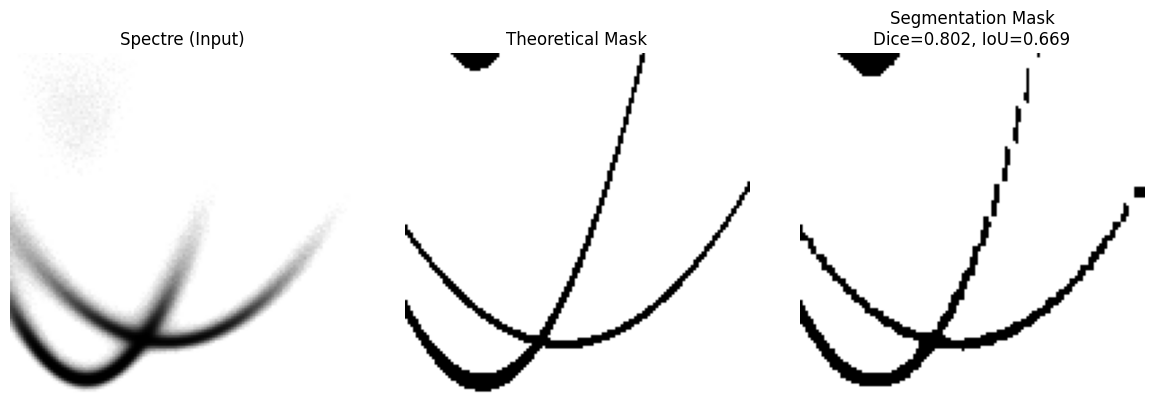

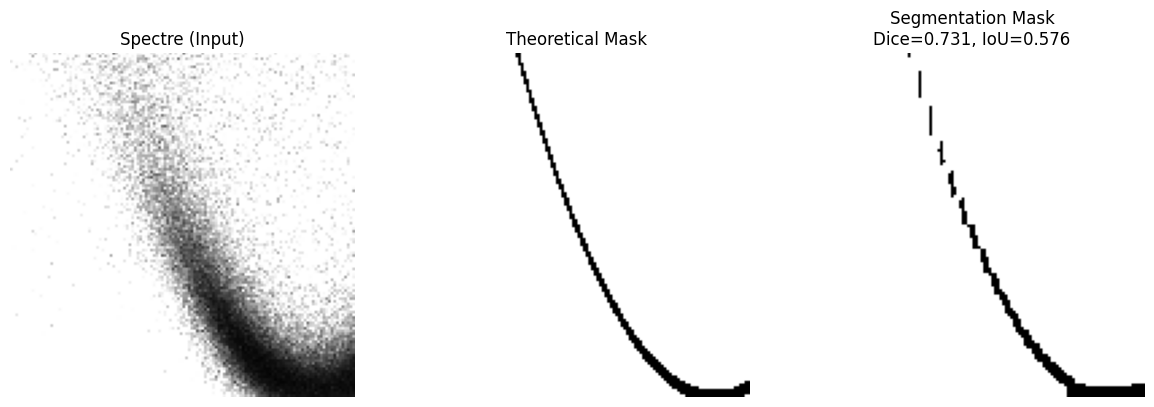

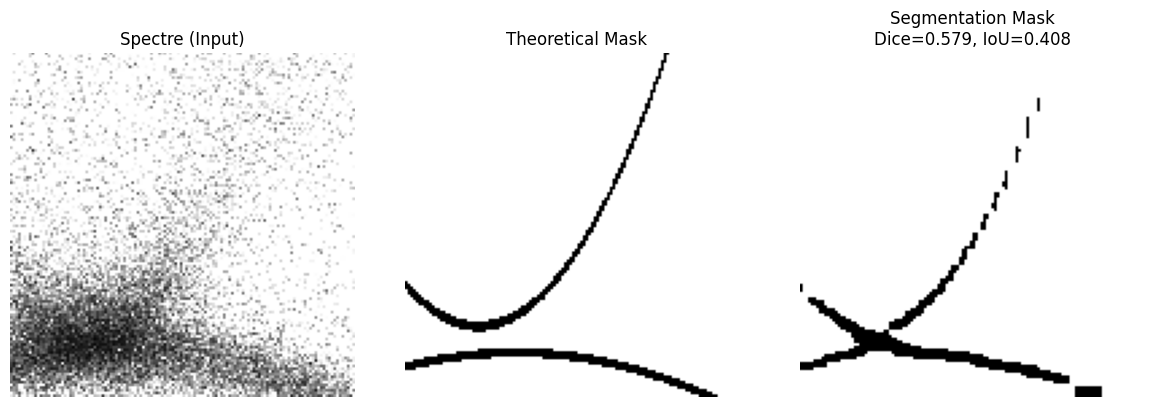

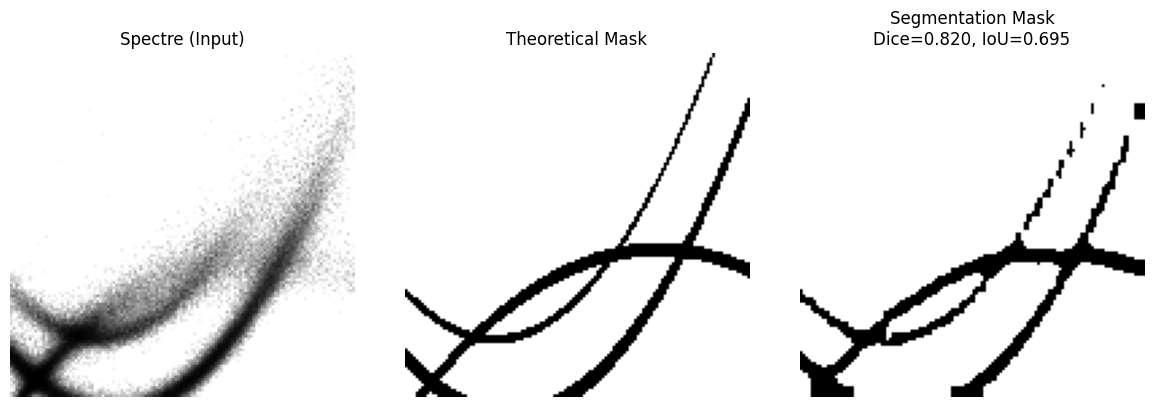

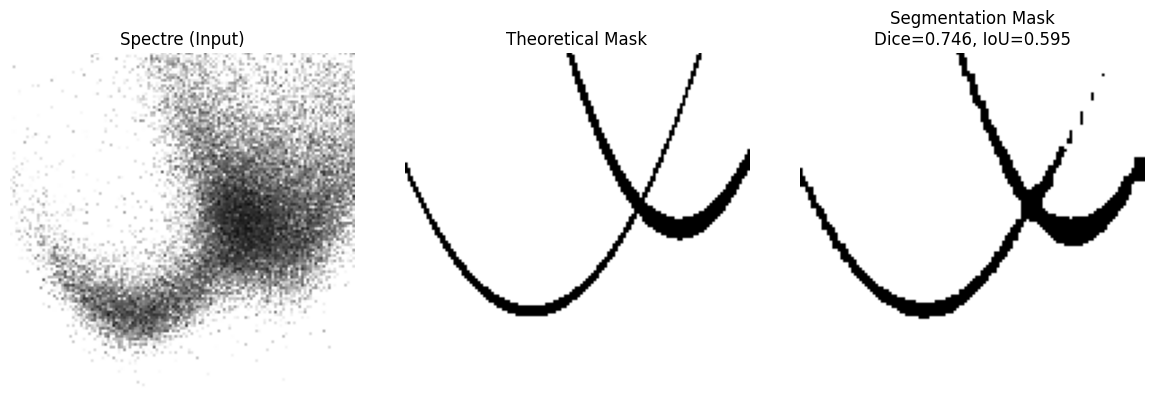

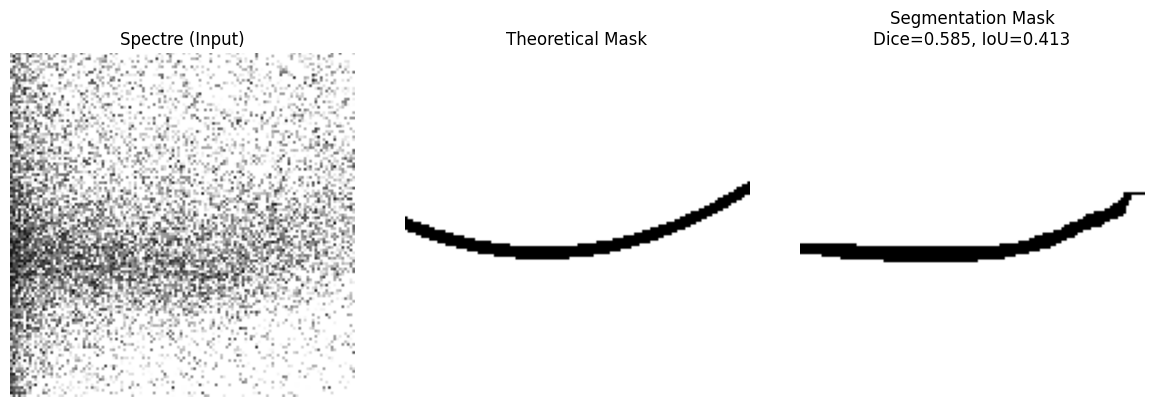

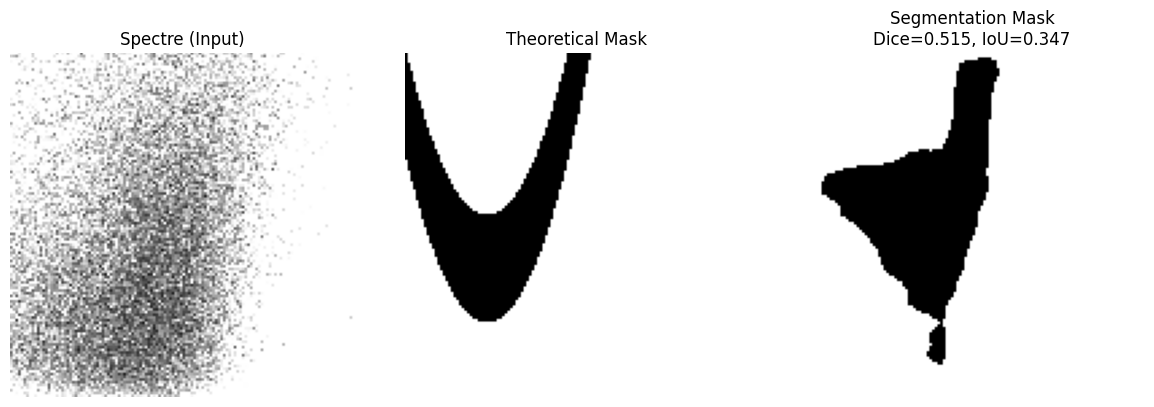

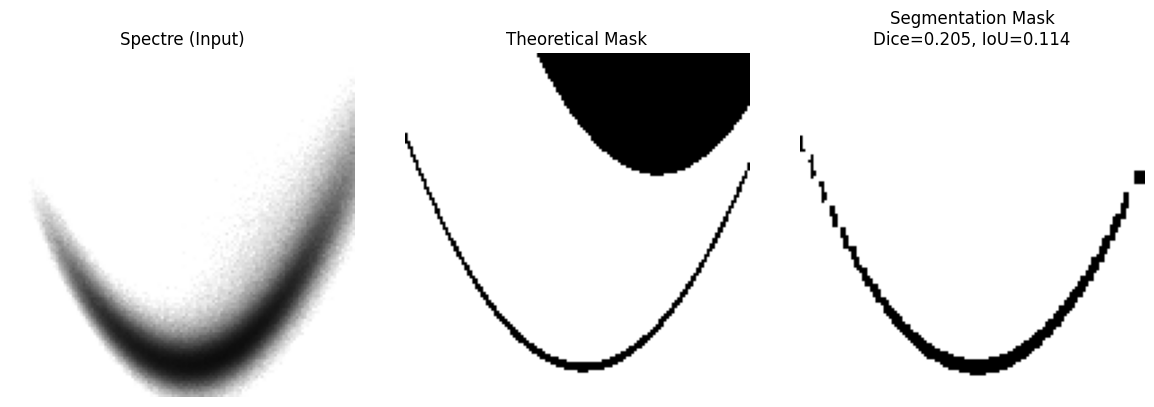

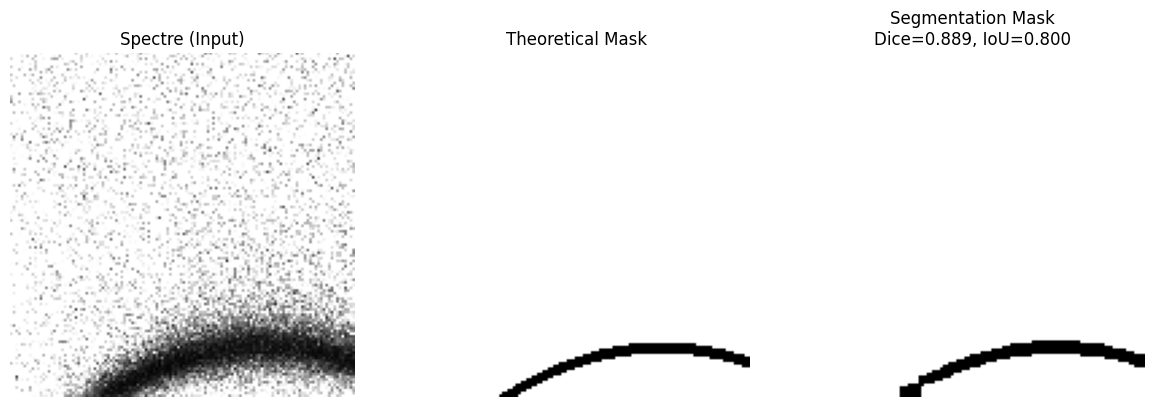

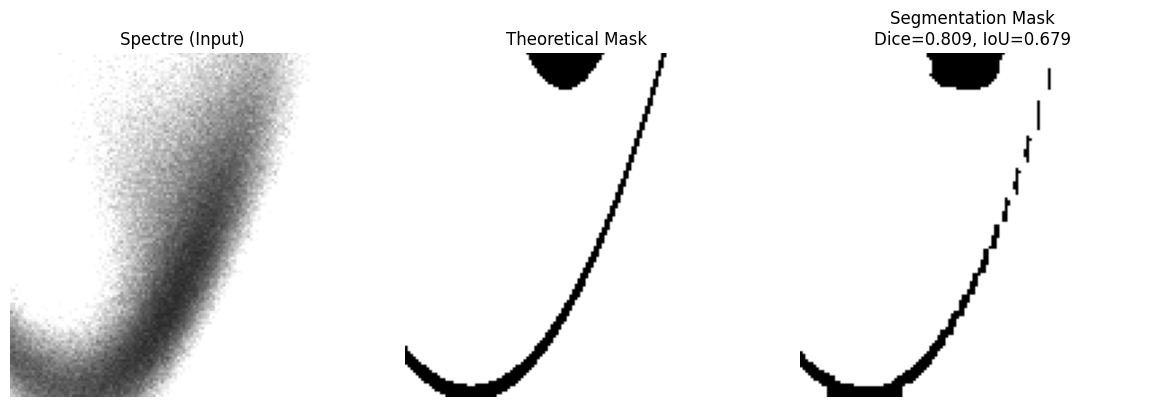

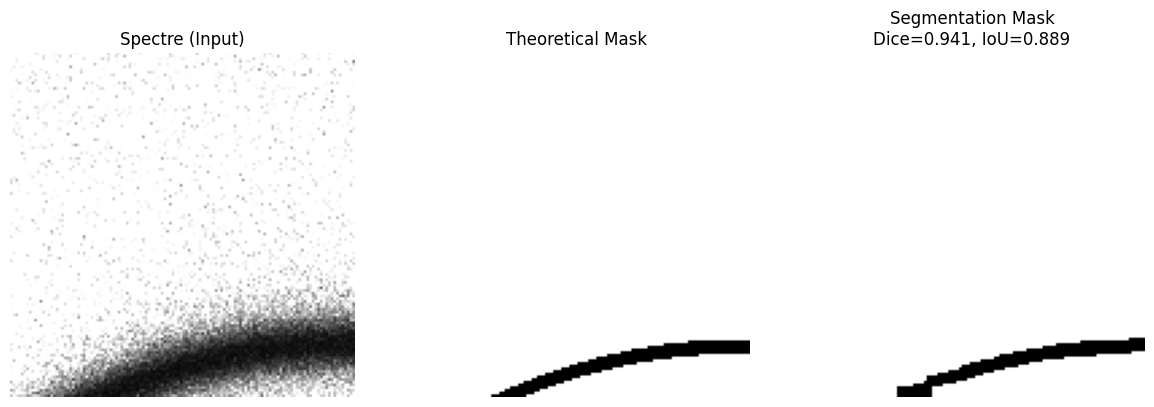

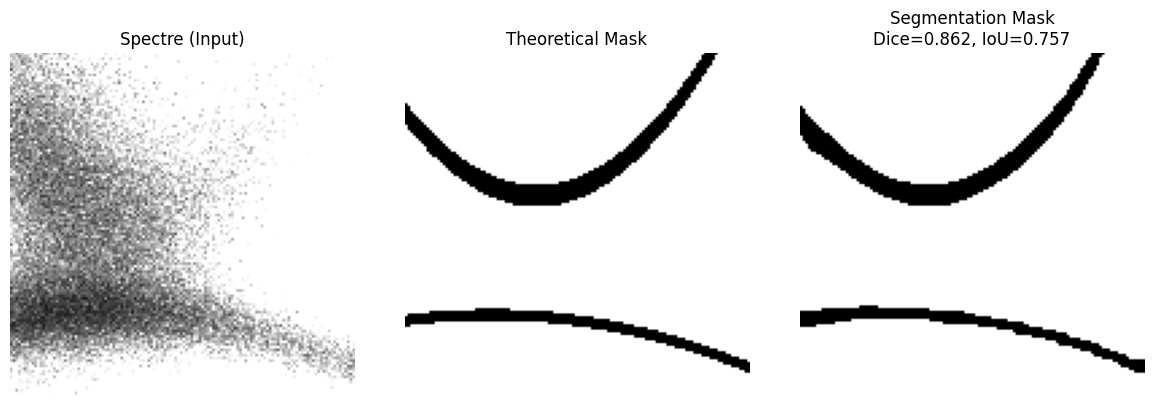

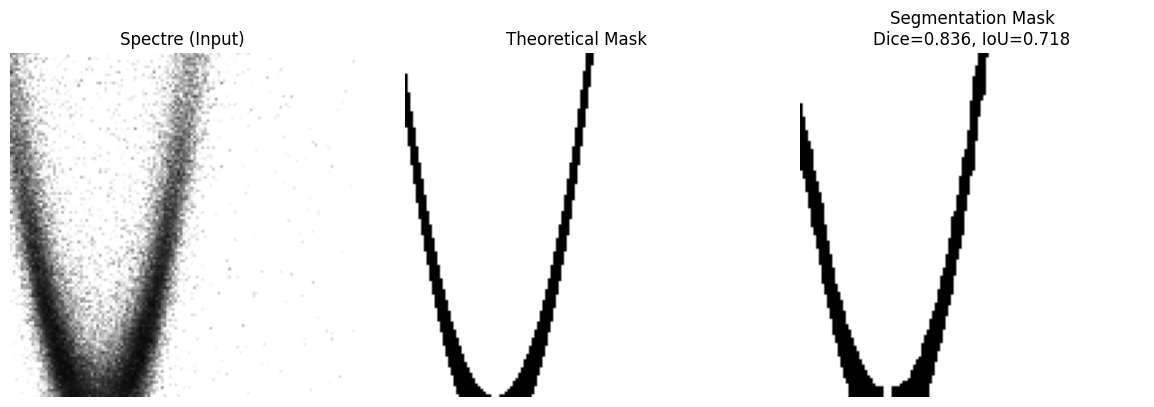

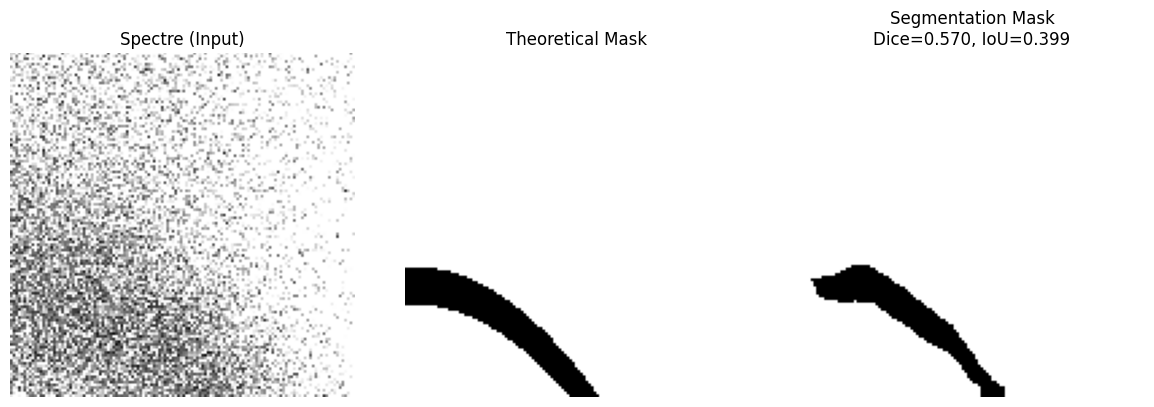

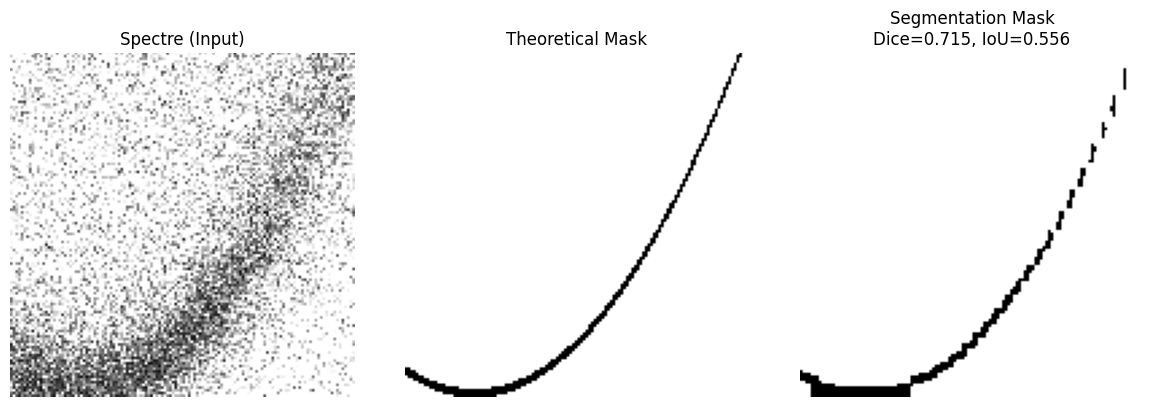

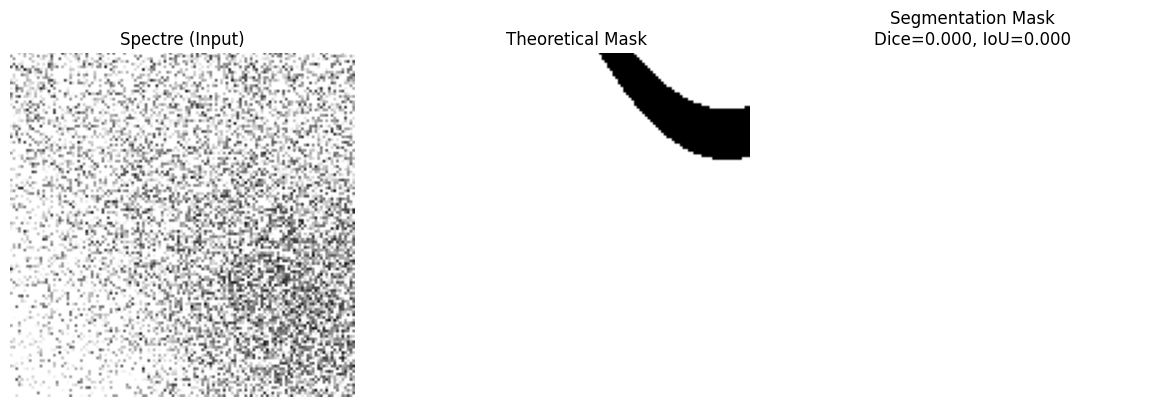

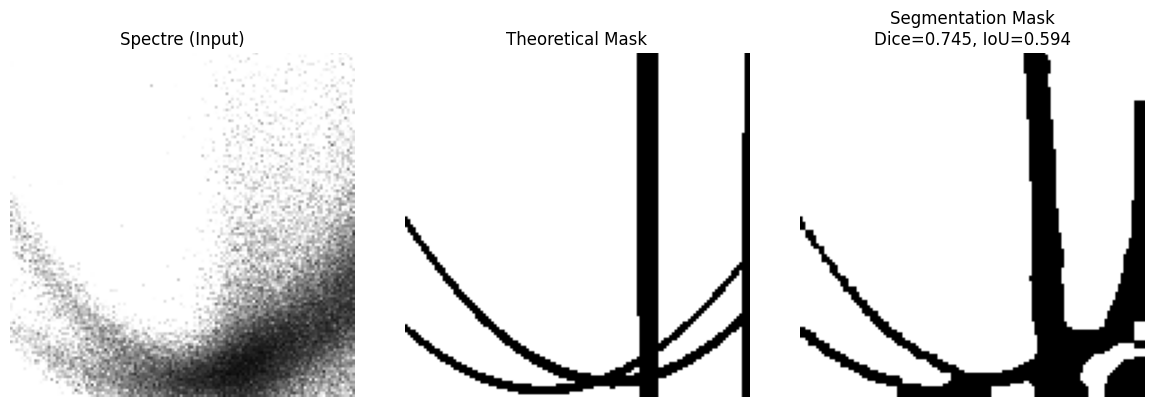

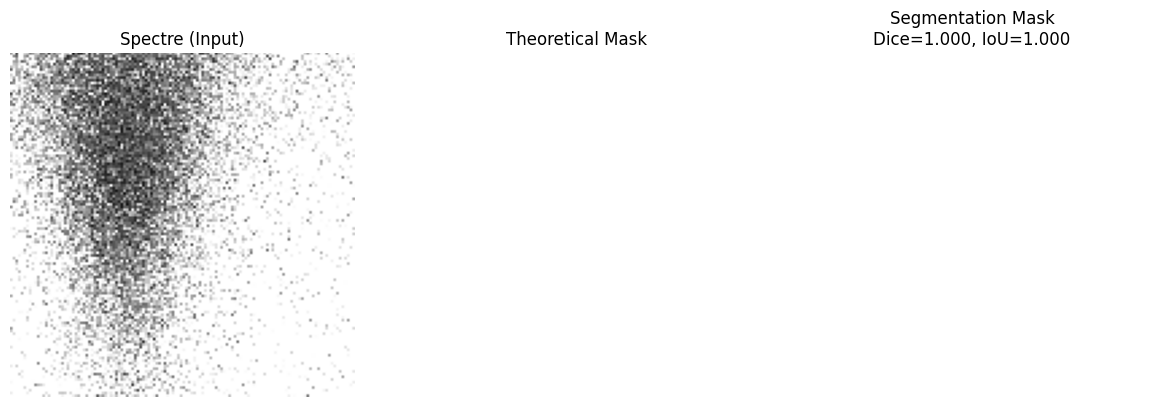

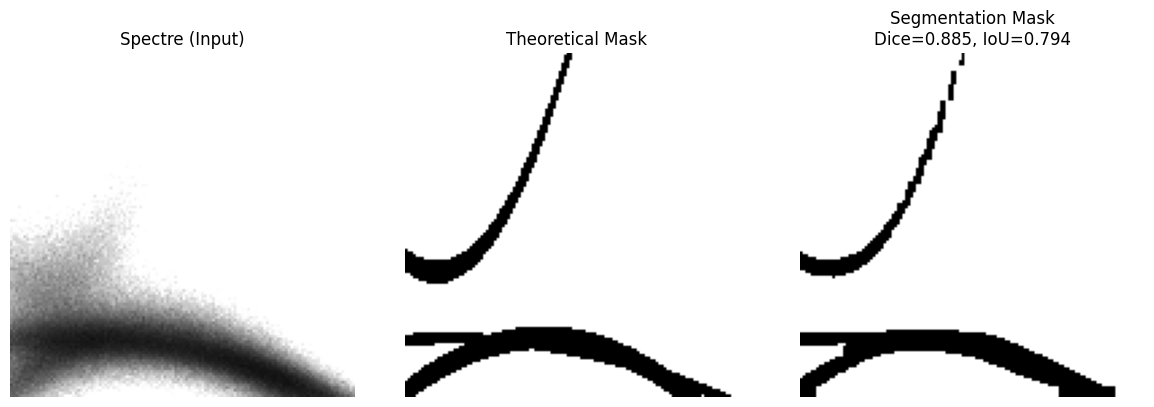

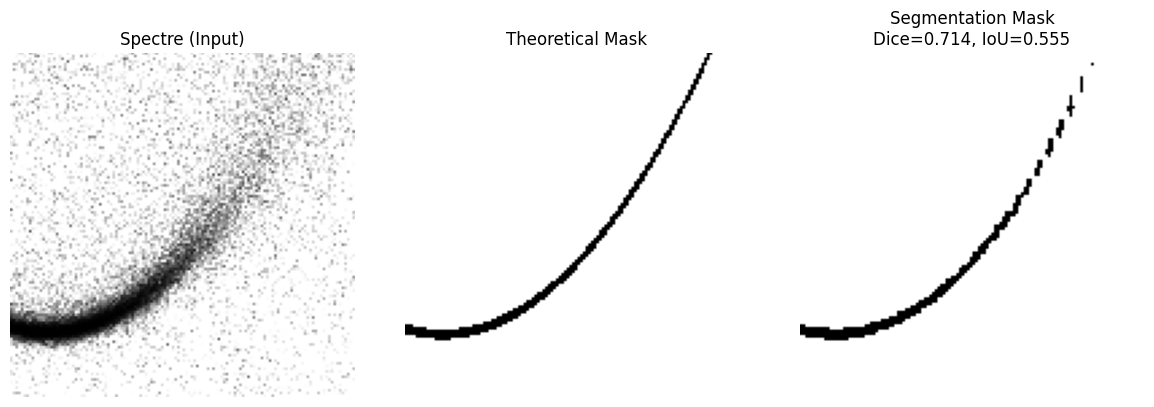

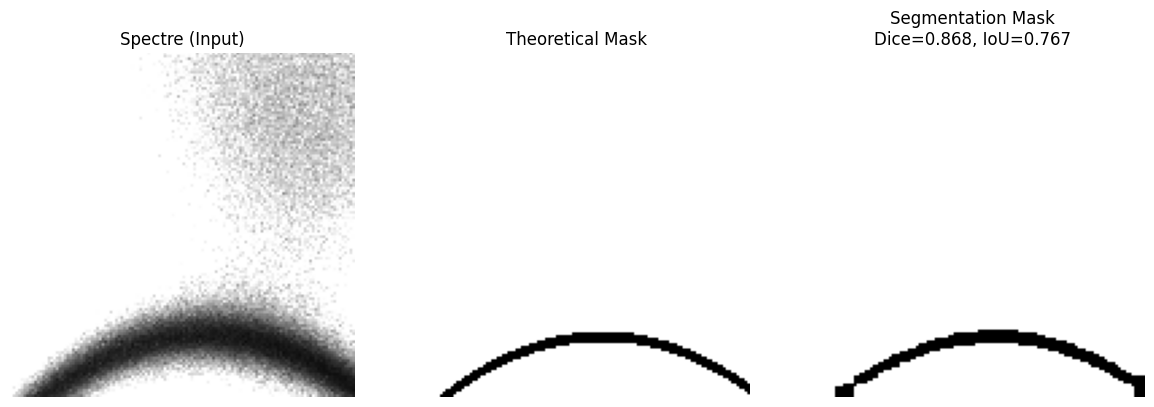

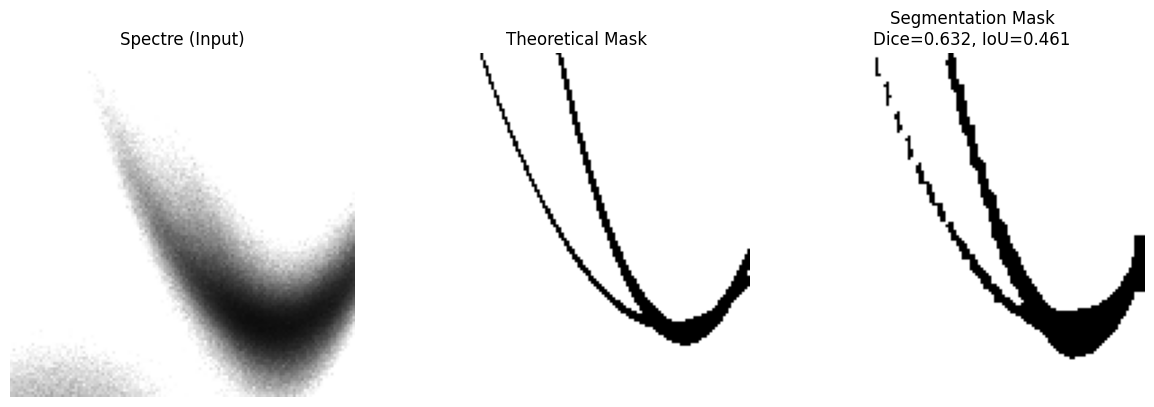

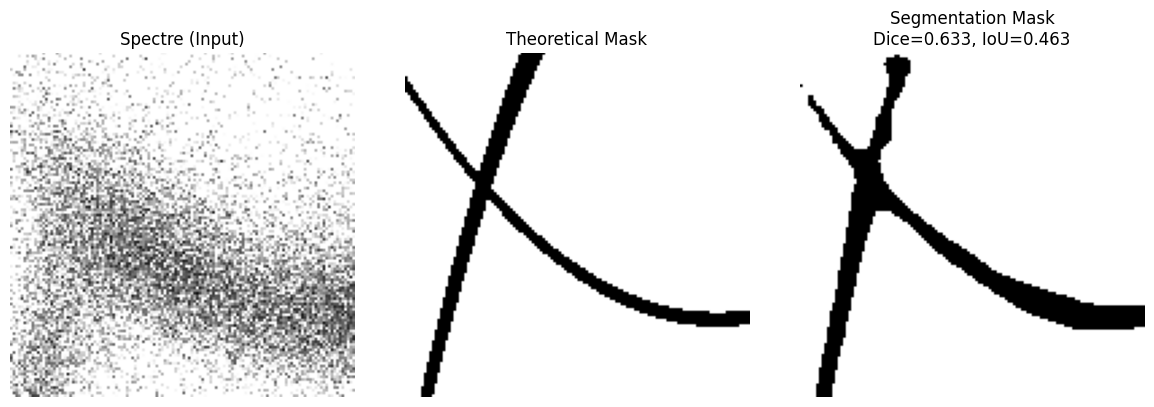

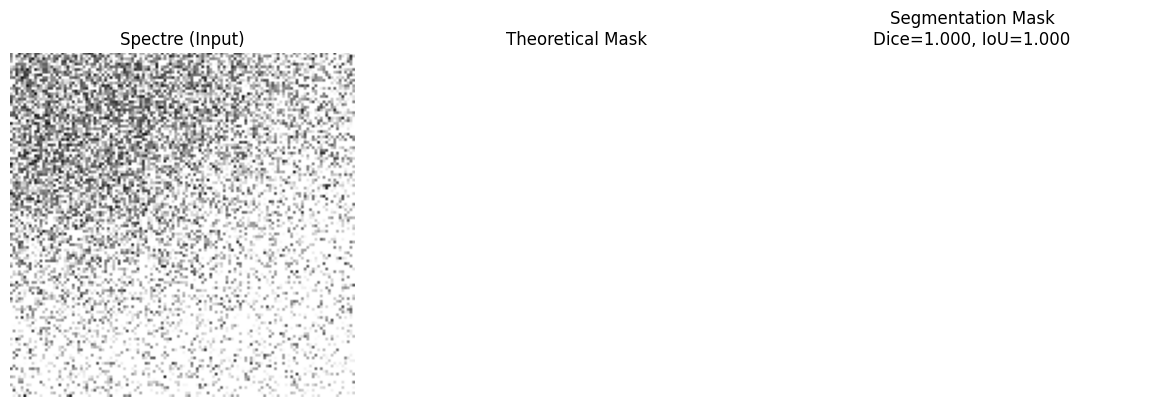

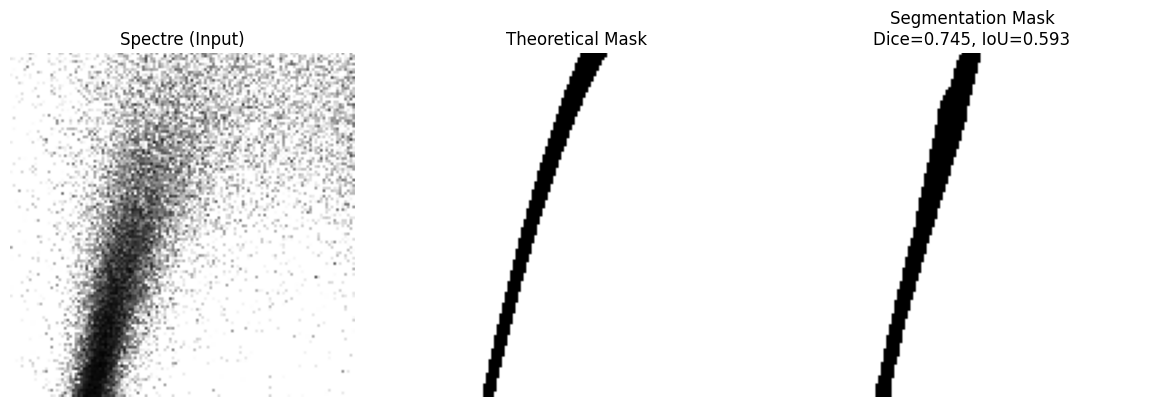

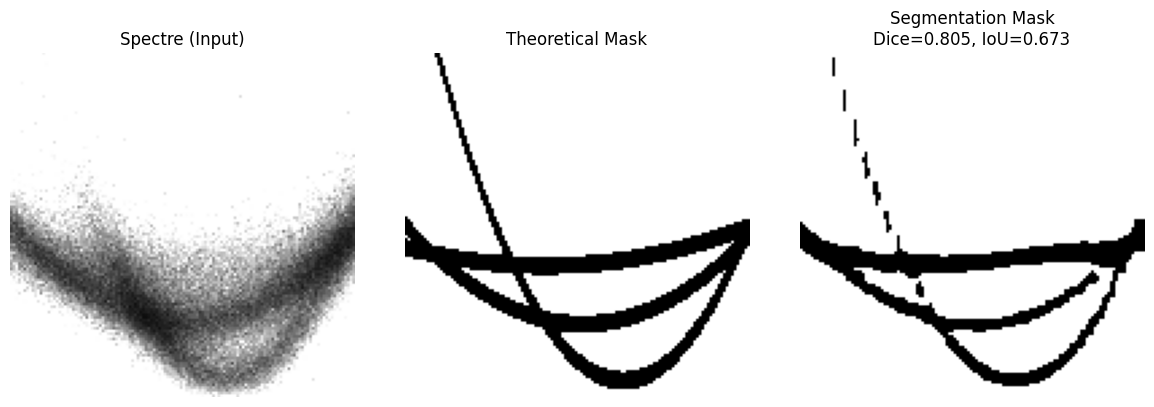

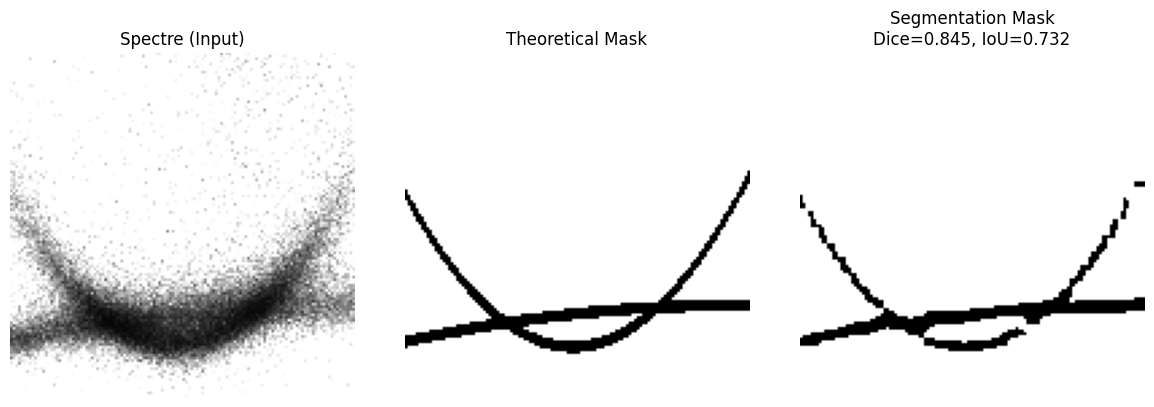

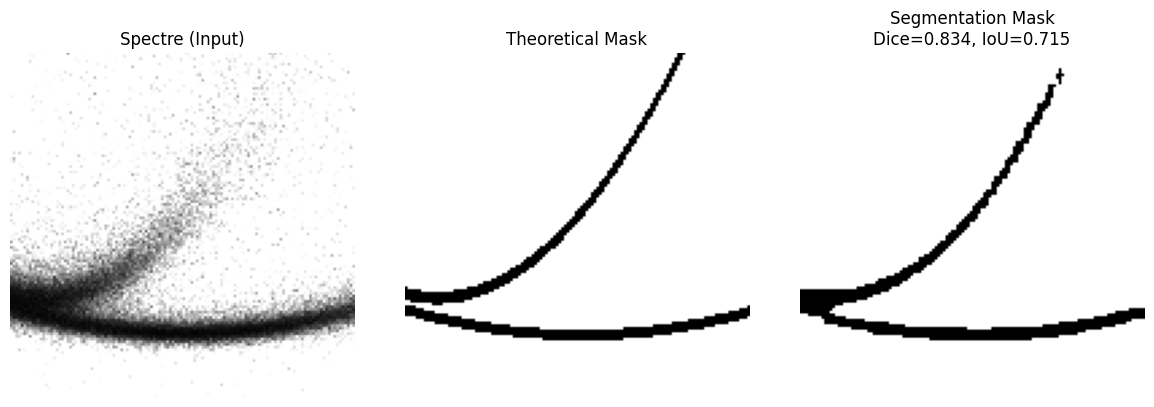

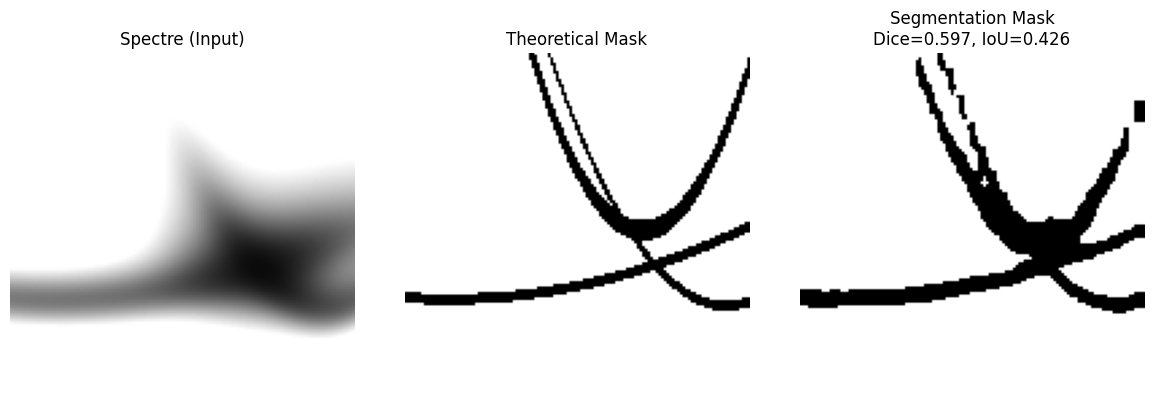

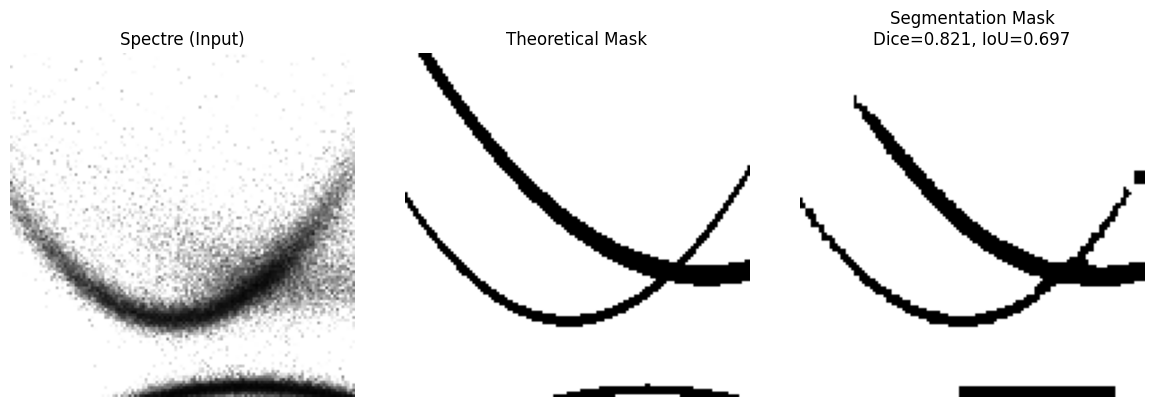

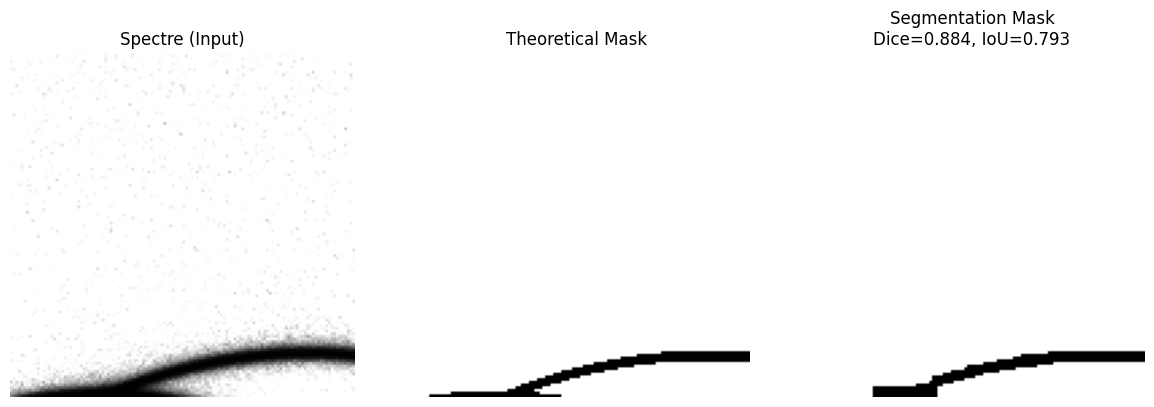

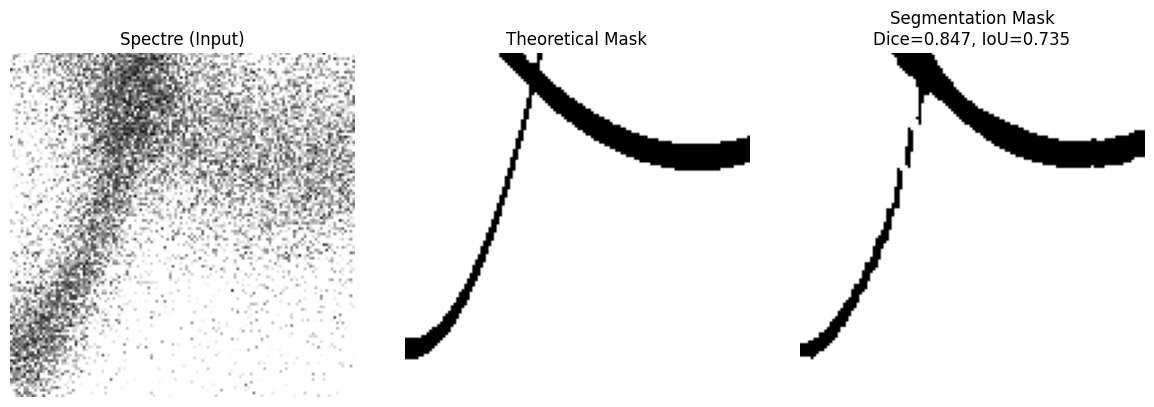

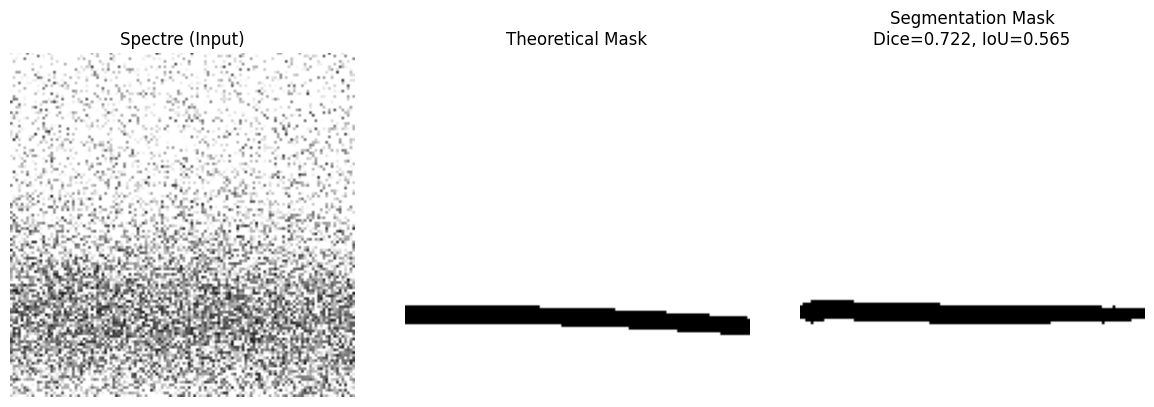

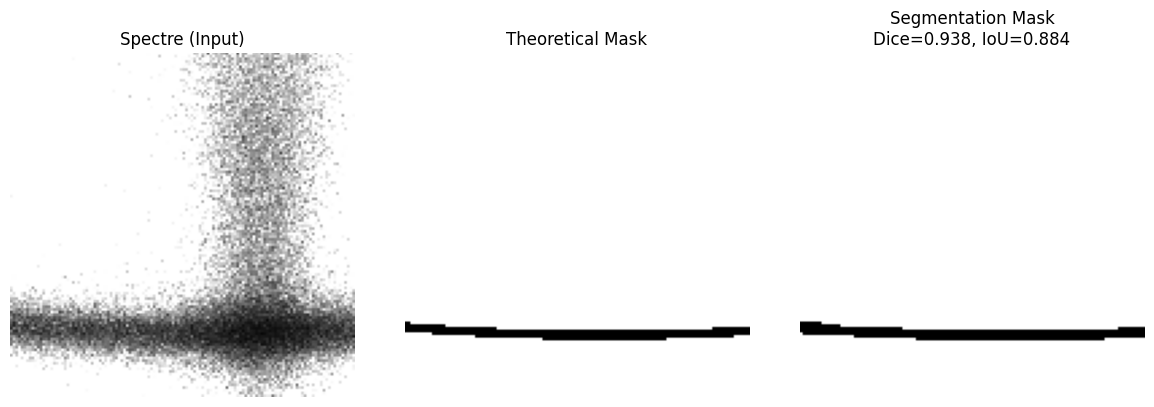

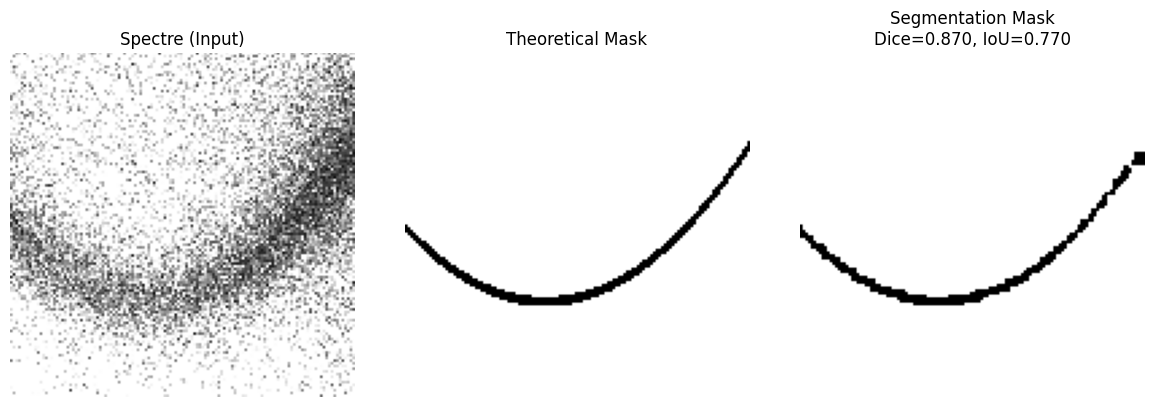

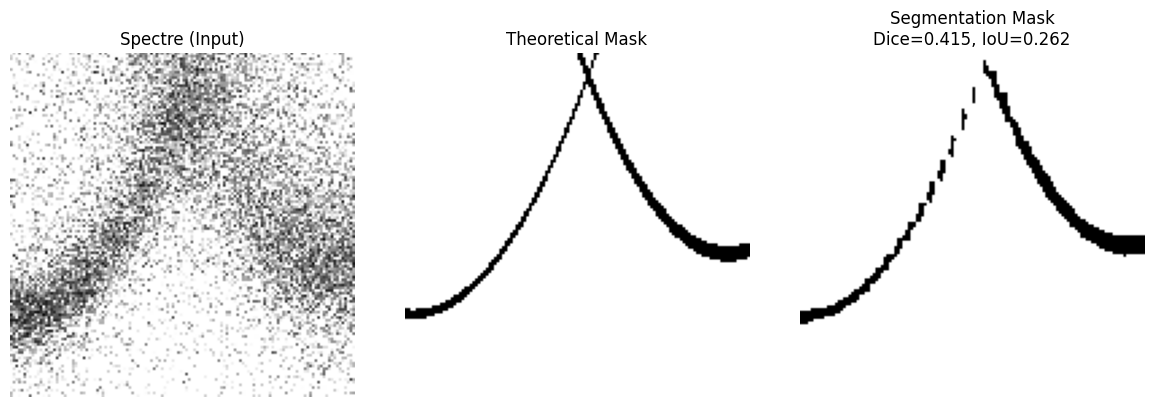

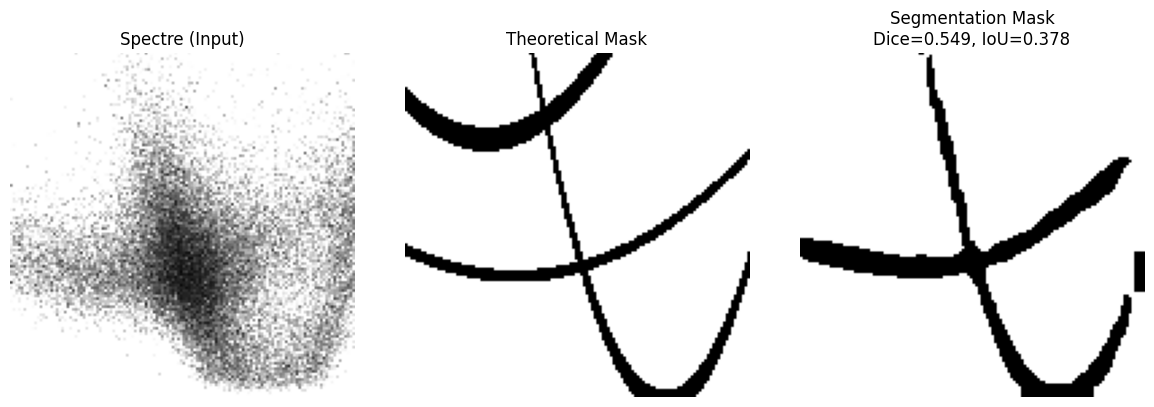

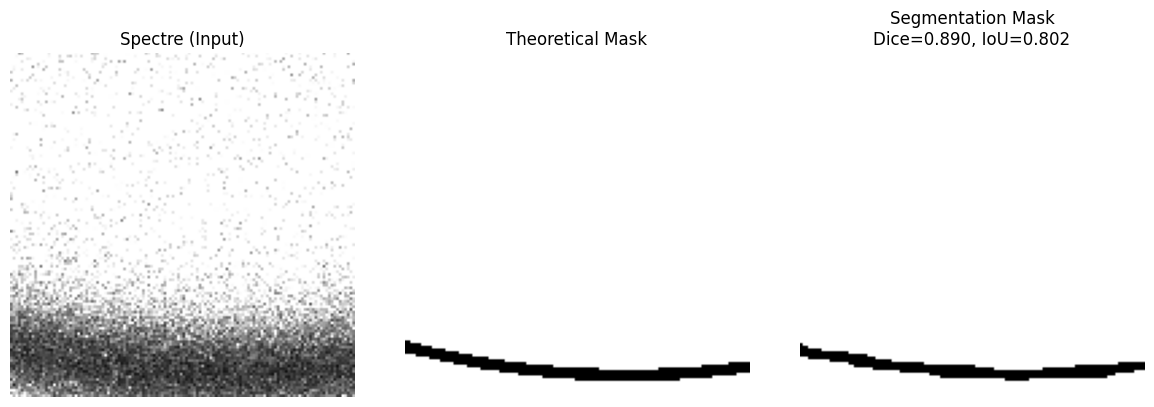

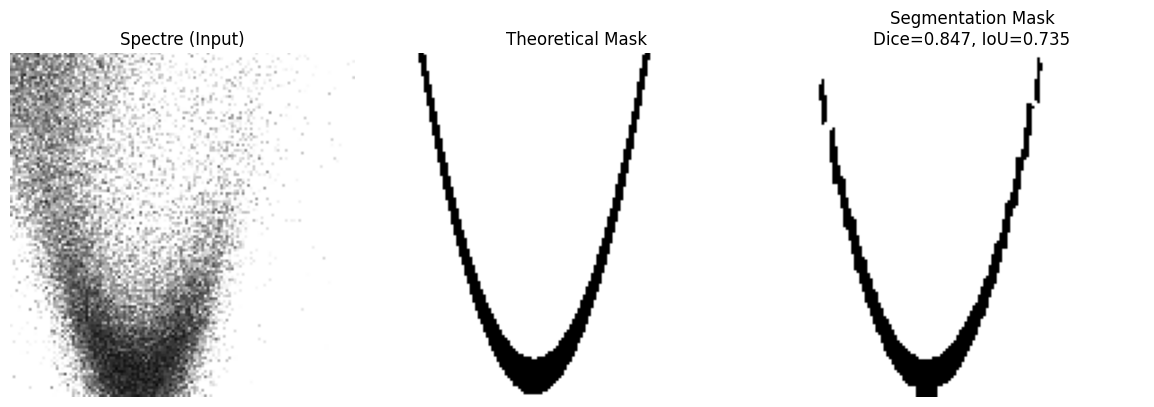

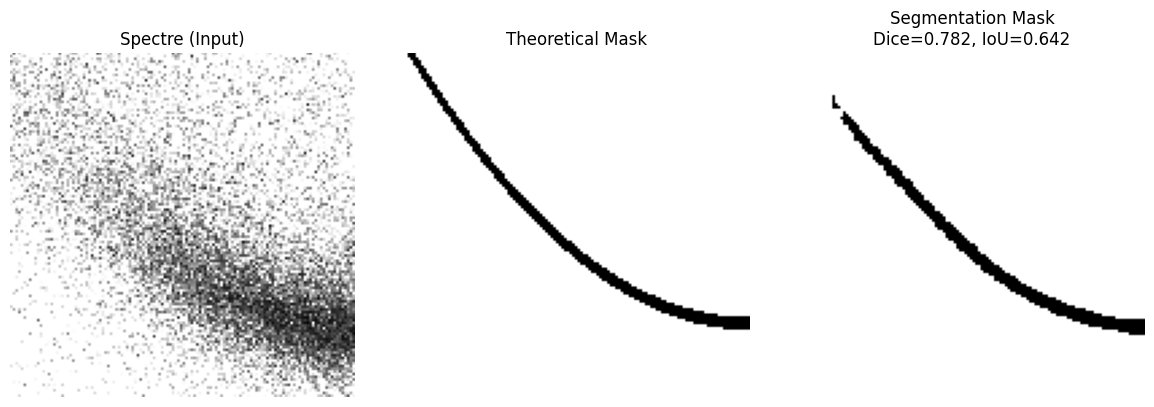

In [24]:
visualize_segmentation_results(
    model=model,
    val_dataset=val_dataset,
    device=device,
    num_samples=40
)

# Visualize on experimental data:

In [9]:
def load_experimental_images(file_paths):
    """
    Loads experimental CSV files, normalizes each to [0,1], and stacks into a single tensor (N, 1, H, W).
    Args:
        file_paths (list of str): Paths to CSV files.

    Returns:
        torch.Tensor: A tensor of shape (N, 1, H, W) where N is the number of images.
                      Each image is normalized to [0,1].
    """
    images = []
    for path in file_paths:
        # Read CSV into DataFrame
        df = pd.read_csv(path)
        arr = df.values.astype('float32')

        # Min-Max Normalize to [0,1]
        arr_min, arr_max = arr.min(), arr.max()
        if arr_max > arr_min:
            arr = (arr - arr_min) / (arr_max - arr_min)
        else:
            # Edge case: if all values are the same, image remains 0.
            arr = arr - arr_min  # All zeros

        # Convert to torch tensor and add a channel dimension => (1, H, W)
        tensor = torch.tensor(arr).unsqueeze(0)
        images.append(tensor)

    # Stack all images => (N, 1, H, W)
    images_tensor = torch.stack(images, dim=0)
    return images_tensor

def visualize_experimental_data(device, model, file_paths, apply_sigmoid=True):
    """
    Loads experimental images, feeds them into the model, visualizes the inputs and outputs,
    and saves each figure to exp_result/result_<n>.png, where <n> continues from the highest
    existing index in that folder.
    """
    # ensure output folder exists
    os.makedirs('exp_result', exist_ok=True)

    # find highest existing index
    existing = [f for f in os.listdir('exp_result') if f.startswith('result_') and f.endswith('.png')]
    nums = []
    for fname in existing:
        try:
            nums.append(int(fname[len('result_'):-4]))
        except ValueError:
            continue
    start_idx = max(nums) + 1 if nums else 0

    # Load and move images to device
    inputs = load_experimental_images(file_paths).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)['out']  # shape: (N, 1, H, W)
        if apply_sigmoid:
            outputs = torch.sigmoid(outputs)

    # Move to CPU for plotting
    inputs = inputs.cpu()
    outputs = outputs.cpu()

    num_images = inputs.size(0)
    for i in range(num_images):
        plt.figure(figsize=(10, 4))

        # Squeeze out batch/channels => (H, W)
        input_img  = inputs[i].squeeze(0).numpy()
        output_img = outputs[i].squeeze(0).numpy()

        # Print shapes & stats
        print(f"Input {i}: shape={input_img.shape}, min={input_img.min():.4f}, max={input_img.max():.4f}")
        print(f"Output {i}: shape={output_img.shape}, min={output_img.min():.4f}, max={output_img.max():.4f}")

        # Plot input
        plt.subplot(1, 2, 1)
        plt.imshow(input_img,  cmap='gray_r')
        plt.title("Experimental Input")
        plt.axis('off')

        # Plot output
        plt.subplot(1, 2, 2)
        plt.imshow(output_img, cmap='gray_r')
        plt.title("Model Output")
        plt.axis('off')

        plt.colorbar()
        plt.tight_layout()

        # determine filename index
        save_idx = start_idx + i
        save_path = os.path.join('exp_result', f"result_{save_idx}.png")
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Saved figure → {save_path}")

        plt.show()
        plt.close()

Input 0: shape=(210, 650), min=0.0000, max=1.0000
Output 0: shape=(210, 650), min=0.0039, max=0.7833
Saved figure → exp_result\result_18.png


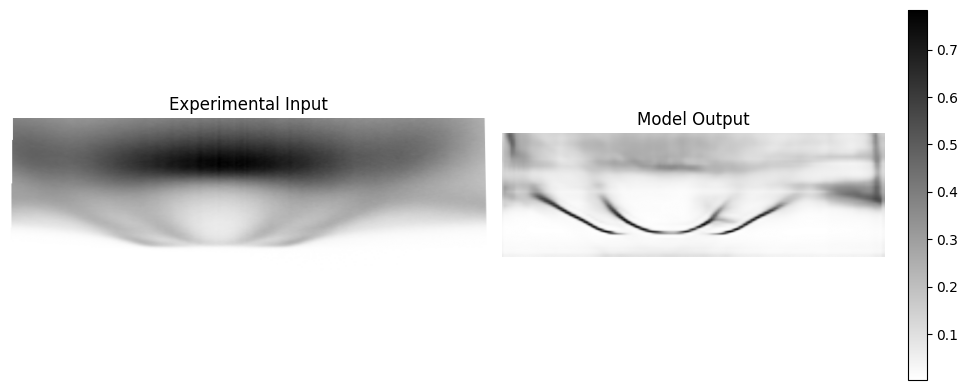

Input 1: shape=(210, 650), min=0.0000, max=1.0000
Output 1: shape=(210, 650), min=0.0041, max=0.7457
Saved figure → exp_result\result_19.png


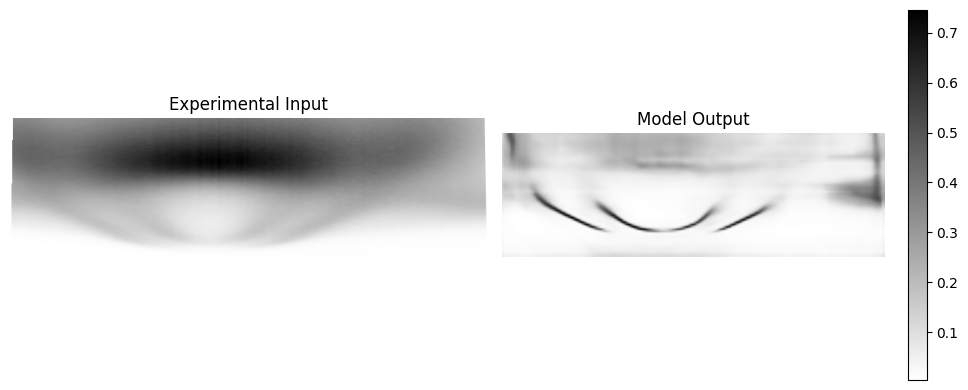

Input 2: shape=(210, 650), min=0.0000, max=1.0000
Output 2: shape=(210, 650), min=0.0021, max=0.6628
Saved figure → exp_result\result_20.png


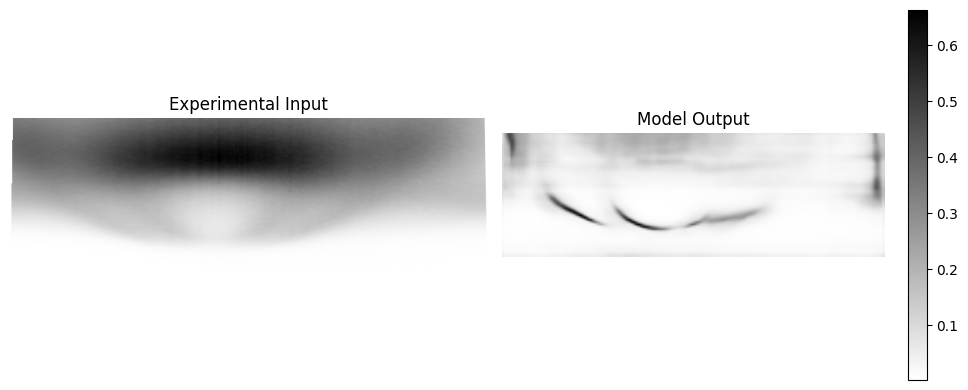

Input 3: shape=(210, 650), min=0.0000, max=1.0000
Output 3: shape=(210, 650), min=0.0035, max=0.5029
Saved figure → exp_result\result_21.png


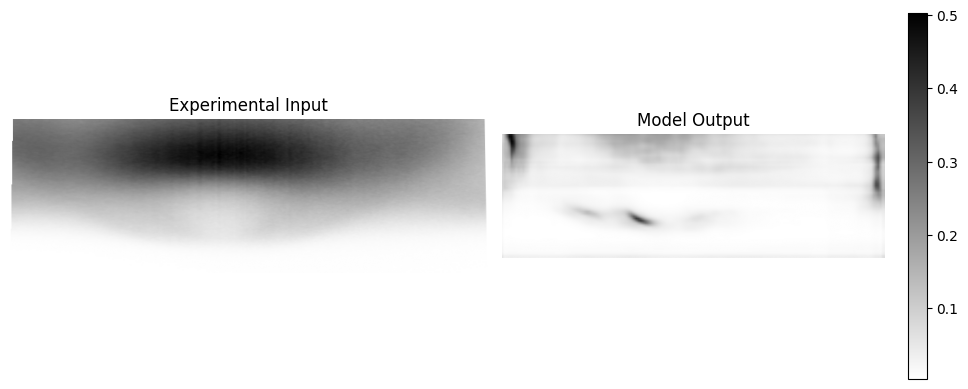

Input 4: shape=(210, 650), min=0.0000, max=1.0000
Output 4: shape=(210, 650), min=0.0032, max=0.5286
Saved figure → exp_result\result_22.png


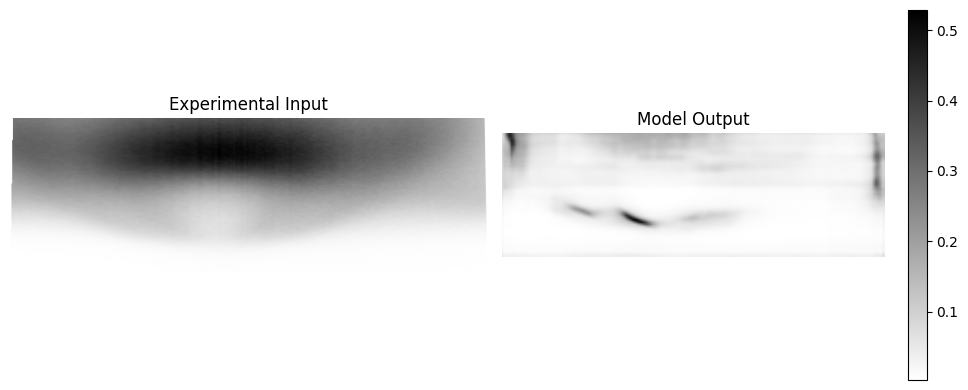

Input 5: shape=(210, 650), min=0.0000, max=1.0000
Output 5: shape=(210, 650), min=0.0026, max=0.4261
Saved figure → exp_result\result_23.png


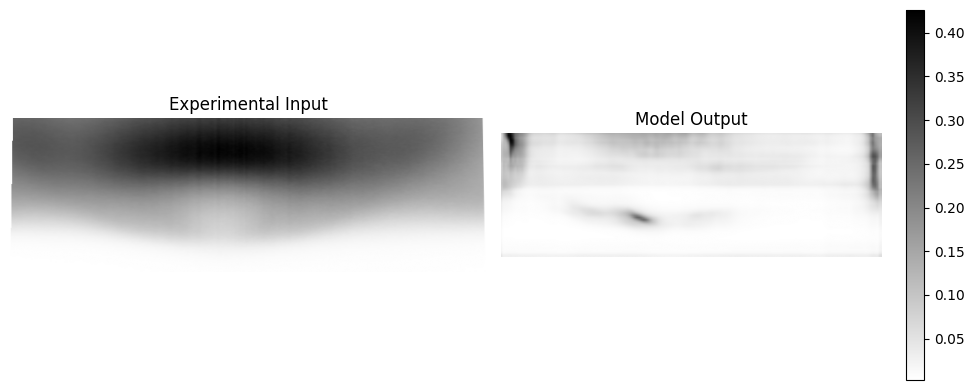

In [15]:
visualize_experimental_data(device, model, [ 'exp_data/LH_T20K_k.csv', 'exp_data/LH_T100K_k.csv', 'exp_data/LH_T160K_k.csv', 'exp_data/LH_T190K_k.csv',  'exp_data/LH_T220K_k.csv', 'exp_data/LH_T250K_k.csv'], apply_sigmoid=True)

Input 0: shape=(146, 250), min=0.0000, max=1.0000
Output 0: shape=(146, 250), min=0.0003, max=0.9671
Saved figure → exp_result\result_17.png


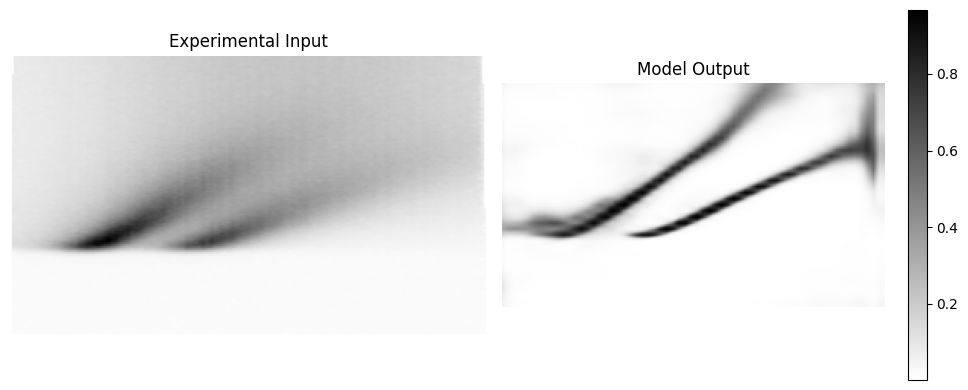

In [11]:
visualize_experimental_data(device, model, ['exp_data/HIN_096.csv'], apply_sigmoid=True)

Input 0: shape=(272, 100), min=0.0000, max=1.0000
Output 0: shape=(272, 100), min=0.0013, max=0.9173
Saved figure → exp_result\result_7.png


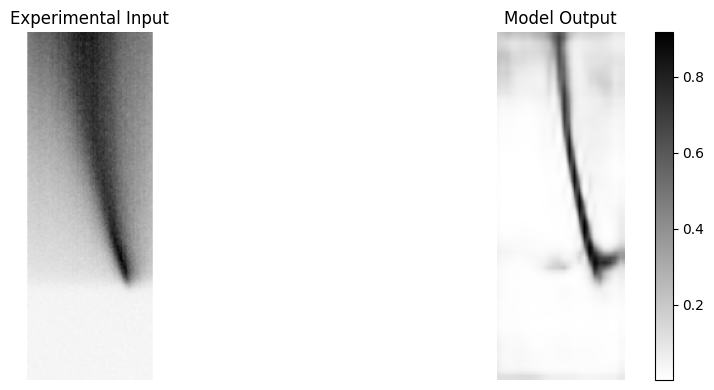

In [16]:
visualize_experimental_data(device, model, [ 'exp_data/LSO_lop069.csv'], apply_sigmoid=True)

Input 0: shape=(249, 100), min=0.0000, max=1.0000
Output 0: shape=(249, 100), min=0.0109, max=0.9494
Saved figure → exp_result\result_8.png


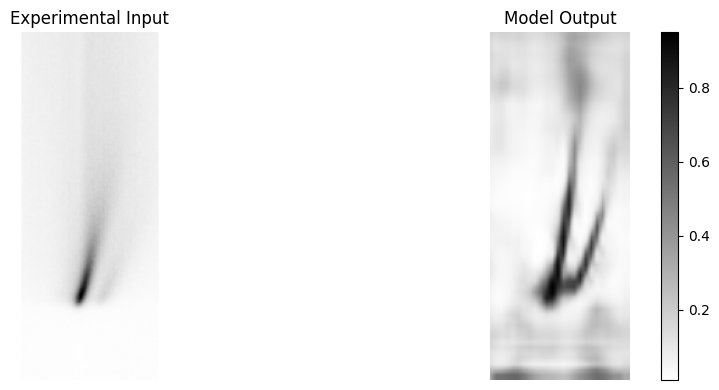

Input 1: shape=(249, 100), min=0.0000, max=1.0000
Output 1: shape=(249, 100), min=0.0157, max=0.9326
Saved figure → exp_result\result_9.png


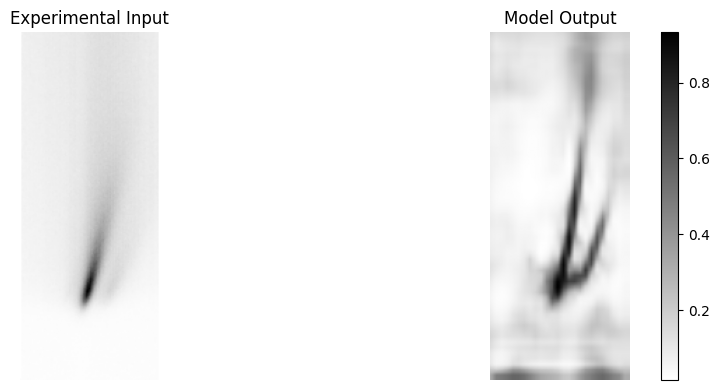

In [17]:
visualize_experimental_data(device, model, ['exp_data/YBUD_074.csv','exp_data/YBUD_077.csv'], apply_sigmoid=True)

Input 0: shape=(300, 572), min=0.0000, max=1.0000
Output 0: shape=(300, 572), min=0.0031, max=0.8975
Saved figure → exp_result\result_10.png


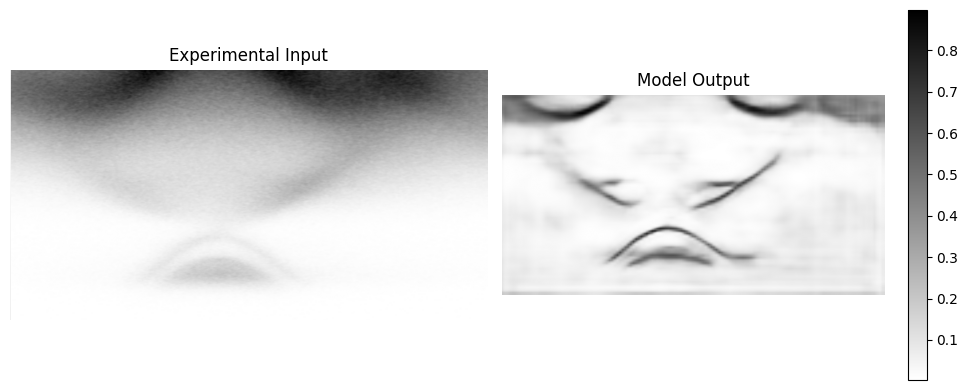

In [18]:
visualize_experimental_data(device, model, [ 'exp_data/sample.csv'], apply_sigmoid=True)

# Visualize on h5 experimental data:

In [19]:
def load_experimental_images_h5(
    file_paths,
    target_energy=None,
    energy_array_key='energy',
    energy_window=1,
    average_energy=False,
    output_dir='slices',
    step=10
):
    """
    Loads experimental HDF5 files containing ARPES data, extracts 2D image slices,
    and saves each selected slice to disk as a PNG.

    If target_energy is None, processes every `step`-th slice to speed things up;
    otherwise extracts only the slice closest to target_energy.

    Args:
        file_paths (list of str]): Paths to HDF5 files.
        target_energy (float or None): Energy (eV) to extract; None => take every `step`-th slice.
        energy_array_key (str): Key for the energy axis data.
        energy_window (int): Half-window size (in slices) if average_energy=True.
        average_energy (bool): If True, average over [slice_idx-energy_window : slice_idx+energy_window].
        output_dir (str): Directory in which to save slice PNGs.
        step (int): Interval between slices when target_energy is None.
    Returns:
        torch.Tensor: Tensor of shape (N, 1, H, W) with values in [0,1].
    """
    os.makedirs(output_dir, exist_ok=True)
    images = []

    for path in file_paths:
        base = os.path.splitext(os.path.basename(path))[0]
        with h5py.File(path, 'r') as f:
            if 'data' not in f:
                raise KeyError(f"'data' key not found in {path}. Keys: {list(f.keys())}")
            arr = f['data'][:].astype('float32')
            if arr.ndim == 4 and arr.shape[0] == 1:
                arr = arr[0]
            if arr.ndim != 3:
                raise ValueError(f"Expected 3D data, got shape {arr.shape}")

            E = arr.shape[-1]
            # Determine which slices to process
            if target_energy is None:
                slice_indices = list(range(0, E, step))
            elif energy_array_key in f:
                energy_axis = f[energy_array_key][:]
                idx = int(np.argmin(np.abs(energy_axis - target_energy)))
                slice_indices = [idx]
            else:
                print(f"Warning: no '{energy_array_key}' axis in {path}; using middle slice.")
                slice_indices = [E // 2]

            # For each selected slice, extract, normalize, save, and convert to tensor
            for slice_idx in slice_indices:
                if average_energy:
                    start = max(0, slice_idx - energy_window)
                    end   = min(E, slice_idx + energy_window + 1)
                    img   = np.mean(arr[..., start:end], axis=-1)
                else:
                    img   = arr[..., slice_idx]

                # background correction & normalization
                img = img - img.min()
                maxv = img.max()
                if maxv > 0:
                    img = img / maxv

                # determine energy for naming
                if energy_array_key in f:
                    energy_val = float(f[energy_array_key][slice_idx])
                    energy_str = f"{energy_val:.3f}eV"
                else:
                    energy_str = f"slice{slice_idx:03d}"

                # save PNG
                out_name = f"{base}_{energy_str}.png"
                out_path = os.path.join(output_dir, out_name)
                plt.imsave(out_path, img, cmap='gray_r')
                print(f"Saved slice {slice_idx} ({energy_str}) → {out_path}")

                # convert to tensor and collect
                tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
                images.append(tensor)

    return torch.stack(images, dim=0)

def visualize_experimental_data_h5(
    device,
    model,
    file_paths,
    target_energy=None,
    energy_array_key='energy',
    energy_window=1,
    average_energy=False,
    apply_sigmoid=True,
    step=10,
    batch_size=4
):
    """
    Loads experimental image slices (every `step`-th slice if target_energy=None),
    runs inference in batches to avoid OOM, visualizes inputs & outputs,
    and saves each figure into exp_result_h5/result_<n>.png, where <n> continues
    from the highest existing index in that folder.
    """
    # 1) Prepare save directory and determine starting index
    save_dir = 'exp_result_h5'
    os.makedirs(save_dir, exist_ok=True)

    existing = [
        fn for fn in os.listdir(save_dir)
        if fn.startswith('result_') and fn.endswith('.png')
    ]
    nums = []
    for fn in existing:
        try:
            nums.append(int(fn[len('result_'):-4]))
        except ValueError:
            pass
    start_idx = max(nums) + 1 if nums else 0

    # 2) Load all slices (CPU) and save any new slice PNGs via load_experimental_images_h5
    inputs = load_experimental_images_h5(
        file_paths,
        target_energy=target_energy,
        energy_array_key=energy_array_key,
        energy_window=energy_window,
        average_energy=average_energy,
        output_dir='slices',
        step=step
    )  # returns a CPU tensor shape (N,1,H,W)

    model.eval()
    total = inputs.size(0)
    for batch_start in range(0, total, batch_size):
        batch_end = min(total, batch_start + batch_size)
        batch = inputs[batch_start:batch_end].to(device, non_blocking=True)

        with torch.no_grad():
            out = model(batch)['out']
            if apply_sigmoid:
                out = torch.sigmoid(out)

        out = out.cpu()

        # 3) Visualize & save each slice in this batch
        for i in range(batch_end - batch_start):
            idx_global = batch_start + i
            inp_img  = batch[i].cpu().squeeze(0).numpy()
            out_img  = out[i].squeeze(0).numpy()

            print(f"[Slice {idx_global}] in(min,max)=({inp_img.min():.4f},{inp_img.max():.4f}) "
                  f"out(min,max)=({out_img.min():.4f},{out_img.max():.4f})")

            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
            ax0.imshow(inp_img,  cmap='gray_r')
            ax0.set_title(f"Input #{idx_global}")
            ax0.axis('off')

            im1 = ax1.imshow(out_img, cmap='gray_r')
            ax1.set_title(f"Output #{idx_global}")
            ax1.axis('off')

            fig.subplots_adjust(right=0.85)
            cax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
            fig.colorbar(im1, cax=cax)

            # save with continuous numbering
            save_path = os.path.join(save_dir, f"result_{start_idx + idx_global}.png")
            fig.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"Saved figure → {save_path}")

            plt.show()
            plt.close()

        # free GPU memory
        del batch, out
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
visualize_experimental_data_h5(device, model, [ 'data_h5/Bi2Se3_003.h5'])

In [ ]:
visualize_experimental_data_h5(device, model, [ 'data_h5/MoS2-Au(111)_002.h5'])

In [ ]:
visualize_experimental_data_h5(device, model, [ 'data_h5/TaS2-Au(111)_001.h5'])

In [ ]:
visualize_experimental_data_h5(device, model, [ 'data_h5/WS2-Ag(111)_001.h5'])